# __Machine Learning for Prioritizing Blood Pressure Genes__ 

In [116]:
import re

import numpy as np
import pandas as pd
import scipy.cluster
from numpy import absolute, mean, sort, std
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

import matplotlib.pylab as plt
import seaborn as sns
import shap
import statsmodels.api as sm

%matplotlib inline
%config InlineBackend.figure_format ='retina'
from lightgbm import LGBMRegressor
from BorutaShap import BorutaShap
from matplotlib.pyplot import cm
import sys
import sklearn.neighbors._base  
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
from sklearn import datasets, metrics, model_selection, preprocessing
from sklearn.metrics import (
    explained_variance_score,
    max_error,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    LeaveOneOut,
    RandomizedSearchCV,
    RepeatedKFold,
    cross_val_predict,
    cross_val_score,
    cross_validate,
    learning_curve,
    train_test_split,
    validation_curve,
)
from skopt import BayesSearchCV
from skopt.plots import plot_convergence

sns.set_style("darkgrid")
sns.mpl.rcParams["figure.figsize"] = (15.0, 9.0)

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
from warnings import filterwarnings

filterwarnings("ignore")

seed = 0

In [10]:
data = pd.read_csv("training_cleaned.csv", header=0, sep=",")

In [11]:
data["label_encoded"] = data["label"].map(
    {"most likely": 1, "probable": 0.75, "least likely": 0.1}
)
Y = data["label_encoded"]
data = data.drop(["label"], 1)
data.shape

(821, 30)

### Load Boruta Shap Feature Selected Features

In [12]:
X = pd.read_csv("selected_features_training_data.csv", header=0)
X.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X.columns.values
]

In [13]:
df_gene = data[["Gene"]]

X = pd.concat([df_gene, X], axis=1)

X = X.set_index("Gene")

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [15]:
# Model parameters built from repeated nested CV benchmarking
lgbm =  LGBMRegressor(learning_rate=0.18010356710677633, max_depth=3, n_estimators=50,
              random_state=0, reg_alpha=1, reg_lambda=10)

### Leave One Out Cross-validation

In [16]:
cv = LeaveOneOut()
scores = cross_val_score(lgbm, X, Y, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
scores = absolute(scores)
print("MAE: %.3f (%.3f)" % (mean(scores), std(scores)))

MAE: 0.009 (0.038)


In [17]:
lgbm.fit(X_train, Y_train)
y_true = Y
y_pred = lgbm.predict(X_test)
r2 = r2_score(Y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adj_rsquared = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
print("Adjusted R Squared: {}".format(adj_rsquared))

Adjusted R Squared: 0.4100001341219299


### Predicted r2 vs r2

Predicted r2:
- It removes a data point from the dataset.
- Calculates the regression equation.
- Evaluates how well the model predicts the missing observation.
- And, repeats this for all data points in the dataset.

In [18]:
lgbm.fit(X, Y)
y_true = Y
y_pred = lgbm.predict(X)
xs = X


def press_statistic(y_true, y_pred, xs):
    res = y_pred - y_true
    hat = xs.dot(np.linalg.pinv(xs))
    den = 1 - np.diagonal(hat)
    sqr = np.square(res / den)
    return sqr.sum()


def predicted_r2(y_true, y_pred, xs):
    press = press_statistic(y_true=y_true, y_pred=y_pred, xs=xs)
    sst = np.square(y_true - y_true.mean()).sum()
    return 1 - press / sst


def r2(y_true, y_pred):
    sse = np.square(y_pred - y_true).sum()
    sst = np.square(y_true - y_true.mean()).sum()
    return 1 - sse / sst


print("lgbm r2:", r2(y_true, y_pred))
print("lgbm Predicted r2:", predicted_r2(y_true, y_pred, xs))

lgbm r2: 0.8202887543990549
lgbm Predicted r2: 0.8155570106688115


### Visualize Model Performance:

In [22]:
def perform_repeated_cv(X, Y, model):
    # set random seed for repeartability
    #    random.seed(1)

    # set the number of repetitions
    n_reps = 100

    # perform repeated cross validation
    r2_scores = np.zeros(n_reps)
    mse_scores = np.zeros(n_reps)

    for u in range(n_reps):

        # randomly shuffle the dataset
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X = X.iloc[indices]
        Y = Y.iloc[indices]  # dataset has been randomly shuffled

        # initialize vector to keep predictions from all folds of the cross-validation
        y_predicted = np.zeros(Y.shape)

        # perform 10-fold cross validation
        kf = KFold(n_splits=5)
        for train, test in kf.split(X):

            # split the dataset into training and testing
            X_train = X.iloc[train]
            X_test = X.iloc[test]
            y_train = Y.iloc[train]
            y_test = Y.iloc[test]

            # train model
            lgbm = model
            lgbm.fit(X_train, y_train)

            # make predictions on the testing set
            y_predicted[test] = lgbm.predict(X_test)

        # record scores
        r2_scores[u] = r2_score(Y, y_predicted)
        mse_scores[u] = mean_squared_error(Y, y_predicted)

    # return all scores
    return r2_scores, mse_scores

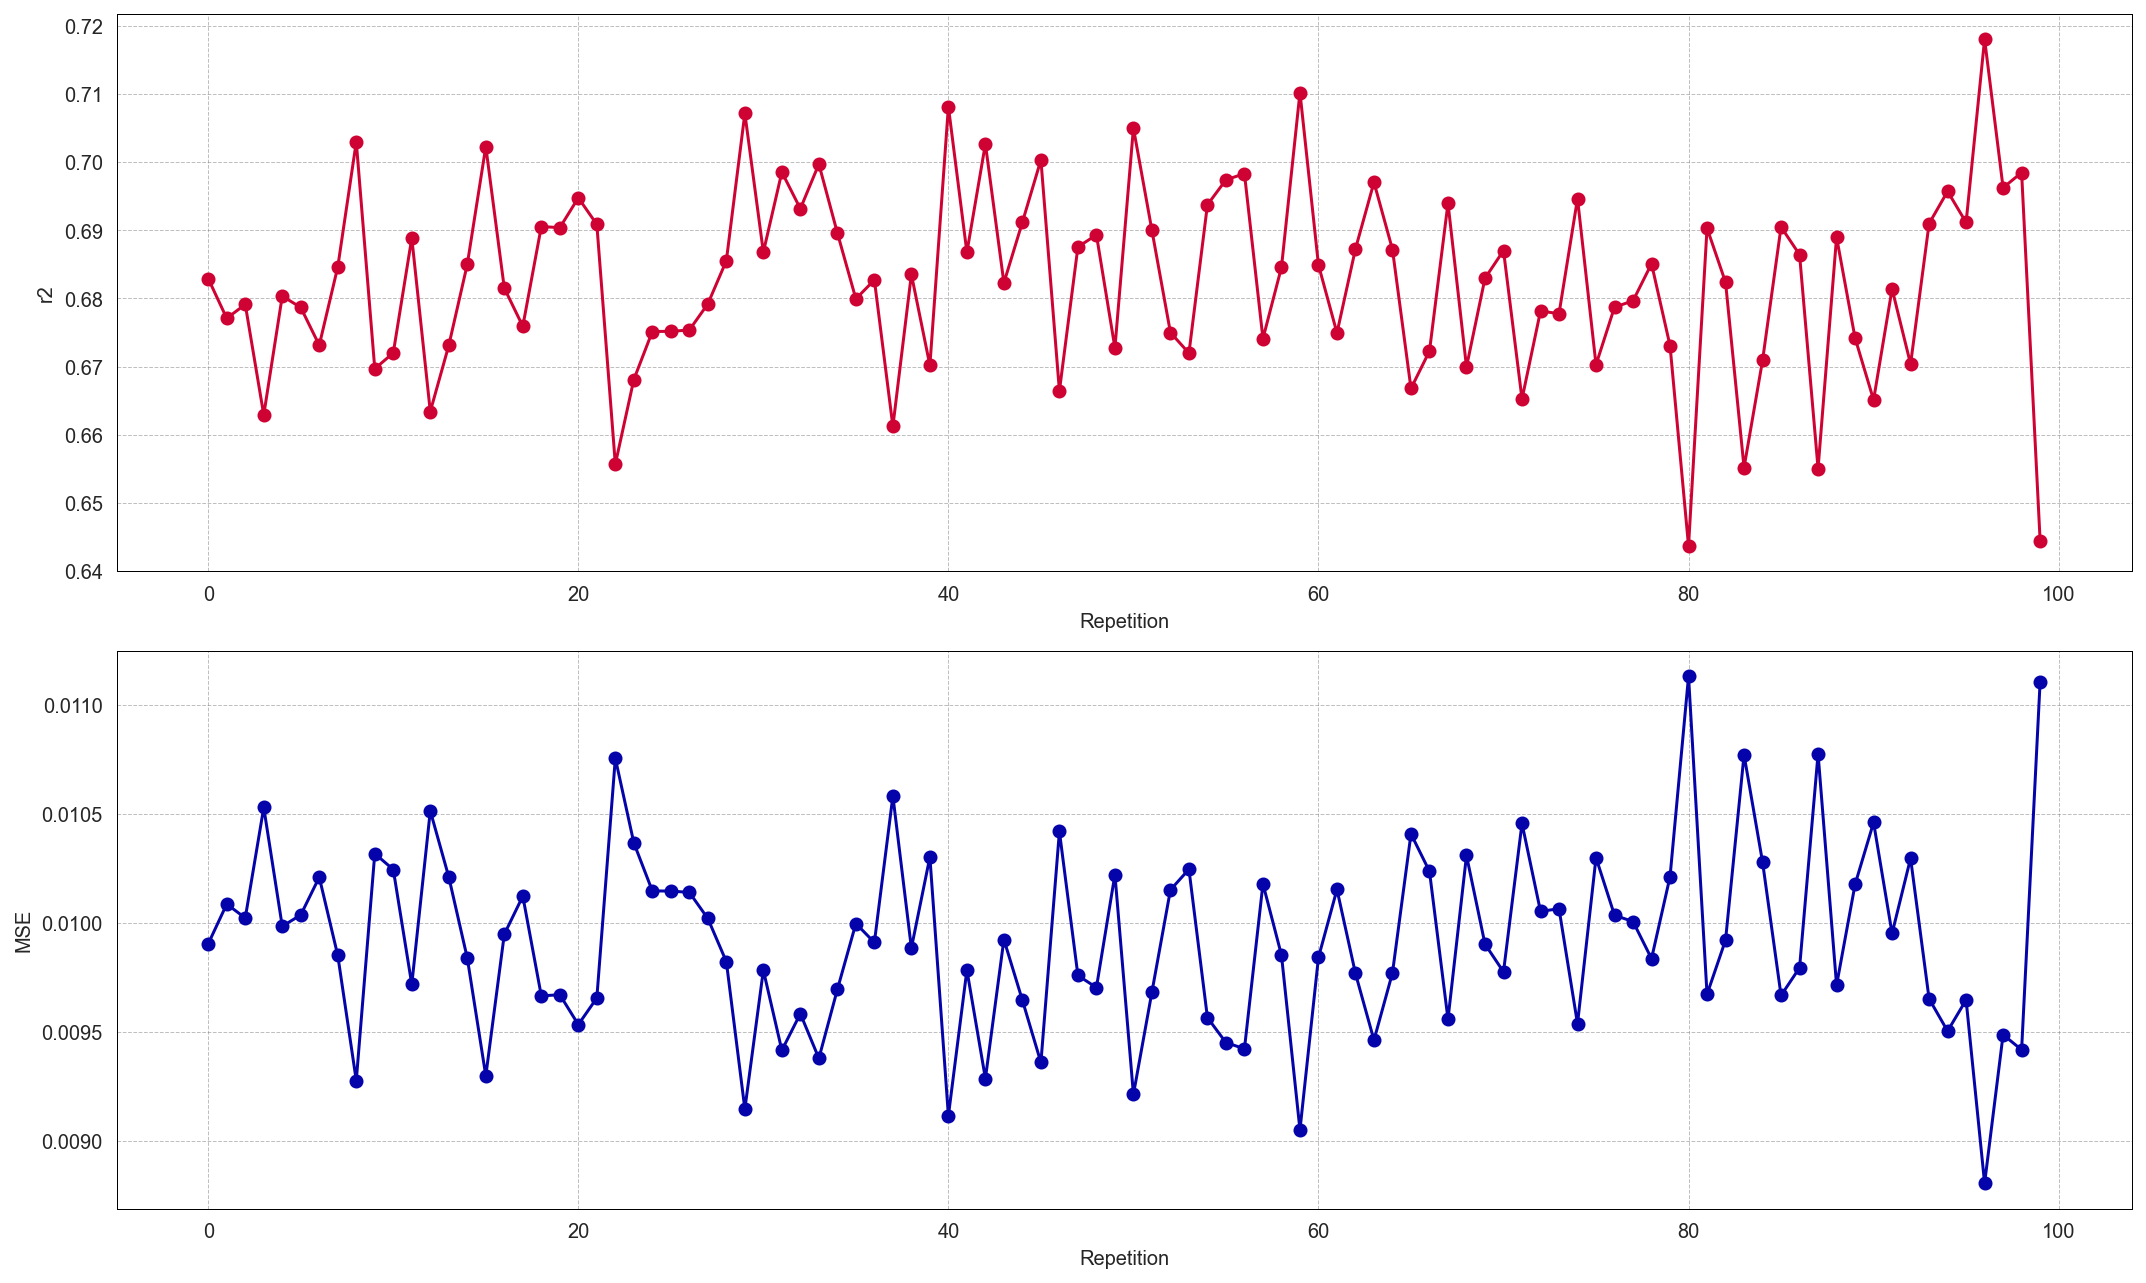

In [23]:
r2_scores, mse_scores = perform_repeated_cv(X, Y, lgbm)

# plot results from the 100 repetitions
fig, axes = plt.subplots(2, 1)

axes[0].plot(r2_scores, color="xkcd:cherry", marker="o")
axes[0].set_xlabel("Repetition")
axes[0].set_ylabel("r2")
axes[0].set_facecolor((1, 1, 1))
axes[0].spines["left"].set_color("black")
axes[0].spines["right"].set_color("black")
axes[0].spines["top"].set_color("black")
axes[0].spines["bottom"].set_color("black")
axes[0].spines["left"].set_linewidth(0.5)
axes[0].spines["right"].set_linewidth(0.5)
axes[0].spines["top"].set_linewidth(0.5)
axes[0].spines["bottom"].set_linewidth(0.5)
axes[0].grid(linestyle="--", linewidth="0.5", color="grey", alpha=0.5)

axes[1].plot(mse_scores, color="xkcd:royal blue", marker="o")
axes[1].set_xlabel("Repetition")
axes[1].set_ylabel("MSE")
axes[1].set_facecolor((1, 1, 1))
axes[1].spines["left"].set_color("black")
axes[1].spines["right"].set_color("black")
axes[1].spines["top"].set_color("black")
axes[1].spines["bottom"].set_color("black")
axes[1].spines["left"].set_linewidth(0.5)
axes[1].spines["right"].set_linewidth(0.5)
axes[1].spines["top"].set_linewidth(0.5)
axes[1].spines["bottom"].set_linewidth(0.5)
axes[1].grid(linestyle="--", linewidth="0.5", color="grey", alpha=0.5)


plt.grid(True)
plt.tight_layout()

### Training Data Prediction Visualization:

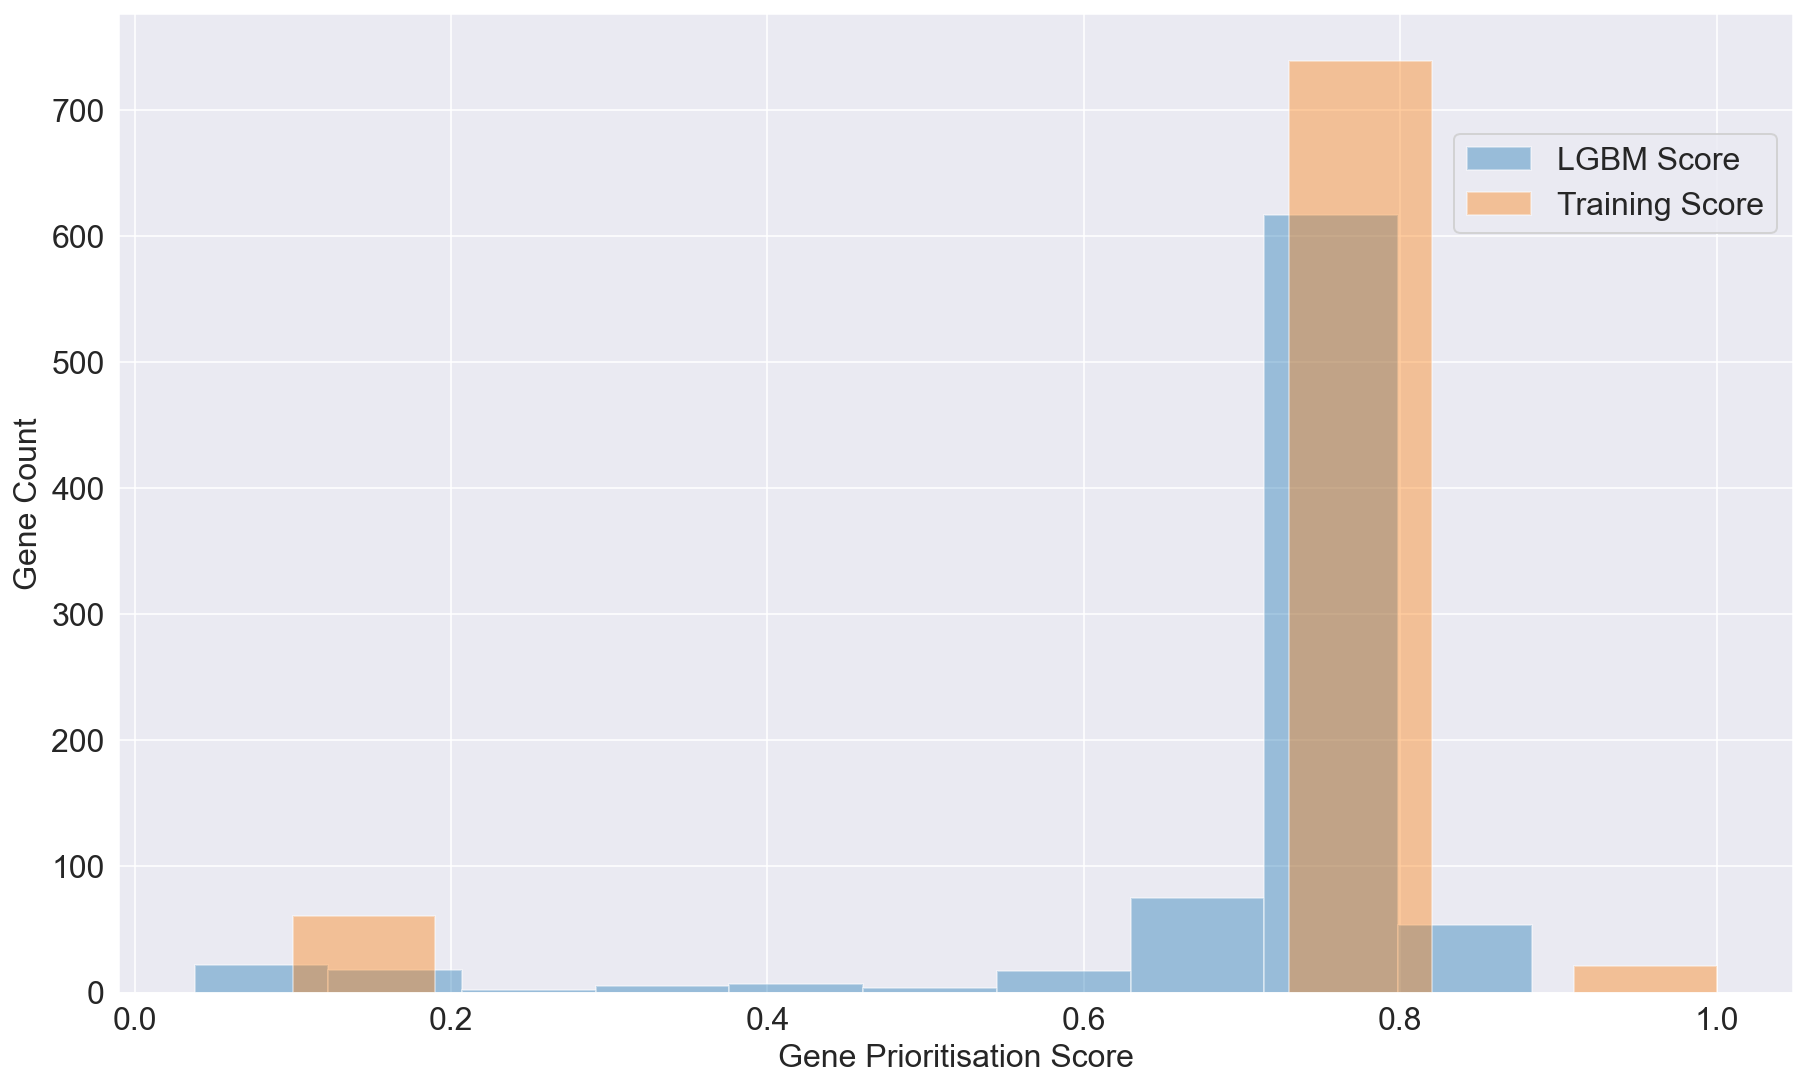

In [24]:
predictions = list(lgbm.predict(X))

output = pd.Series(data=predictions, index=X.index, name="lgbm_Score")

df_total_training = pd.concat([X, output], axis=1)

df_total = pd.concat([X, output], axis=1)

fig, ax = plt.subplots()

sns.distplot(df_total["lgbm_Score"], ax=ax, kde=False, norm_hist=False, bins=10)
sns.distplot(Y, ax=ax, kde=False, bins=10)
fig.legend(
    labels=["LGBM Score", "Training Score"],
    loc="upper right",
    bbox_to_anchor=(0.9, 0.8),
    ncol=1,
    fontsize=16,
)
ax.set_xlabel("Gene Prioritisation Score", fontsize=16)
ax.set_ylabel("Gene Count", fontsize=16)
ax.tick_params(labelsize=16)

In [25]:
predictions = list(lgbm.predict(X))

output = pd.Series(data=predictions, index=X.index, name="lgbm_Score")

output = output.to_frame()
output.reset_index(level=0, inplace=True)

output

Gene  lgbm_Score
0       ABCA1    0.864762
1       ABCG5    0.852003
2     ANGPTL3    0.880503
3       APOA5    0.835528
4        APOB    0.874645
..        ...         ...
816  USP17L19    0.177969
817  USP17L20    0.177969
818  USP17L24    0.179928
819  USP17L26    0.177969
820  USP17L29    0.177969

[821 rows x 2 columns]

In [26]:
print(data[["Gene", "label_encoded"]])

df_b = data[["label_encoded"]]

df_c = pd.concat([output, df_b], axis=1)
df_c

         Gene  label_encoded
0       ABCA1            1.0
1       ABCG5            1.0
2     ANGPTL3            1.0
3       APOA5            1.0
4        APOB            1.0
..        ...            ...
816  USP17L19            0.1
817  USP17L20            0.1
818  USP17L24            0.1
819  USP17L26            0.1
820  USP17L29            0.1

[821 rows x 2 columns]


Gene  lgbm_Score  label_encoded
0       ABCA1    0.864762            1.0
1       ABCG5    0.852003            1.0
2     ANGPTL3    0.880503            1.0
3       APOA5    0.835528            1.0
4        APOB    0.874645            1.0
..        ...         ...            ...
816  USP17L19    0.177969            0.1
817  USP17L20    0.177969            0.1
818  USP17L24    0.179928            0.1
819  USP17L26    0.177969            0.1
820  USP17L29    0.177969            0.1

[821 rows x 3 columns]

### SHAP Feature Importance Visualization:

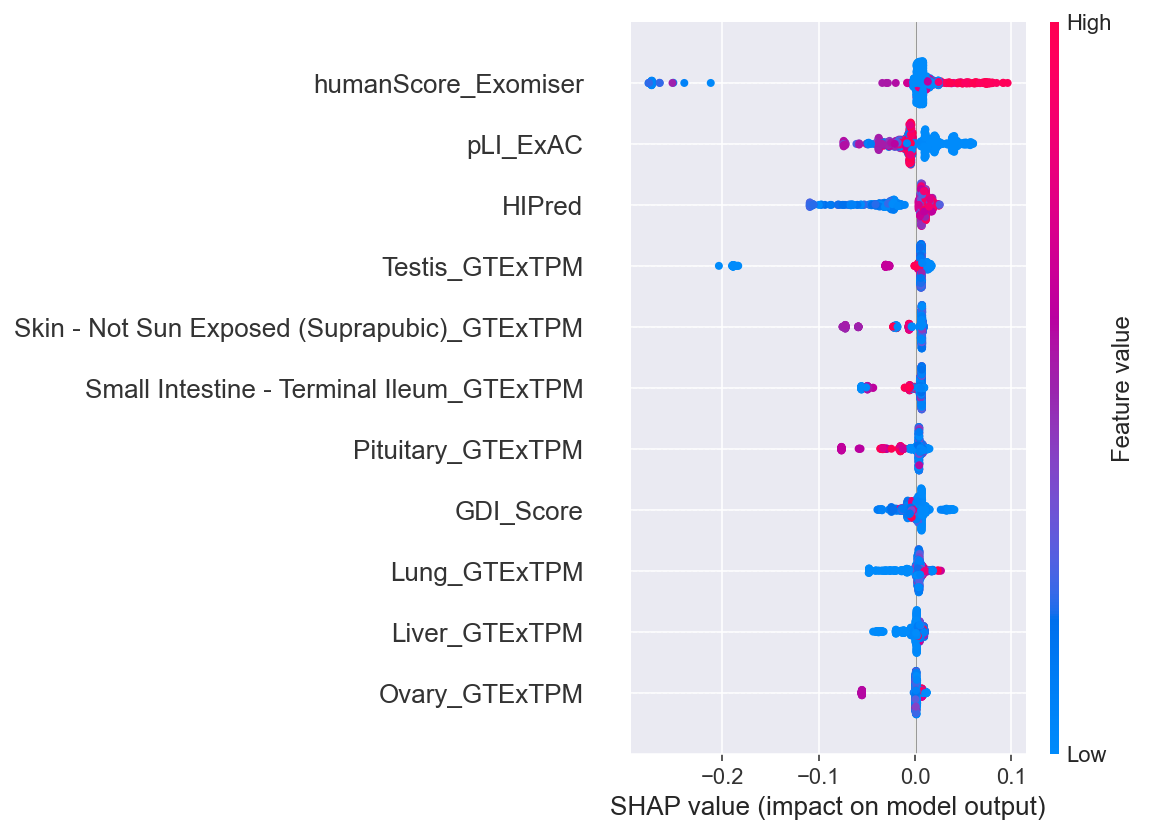

In [27]:
lgbm.fit(X, Y)
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

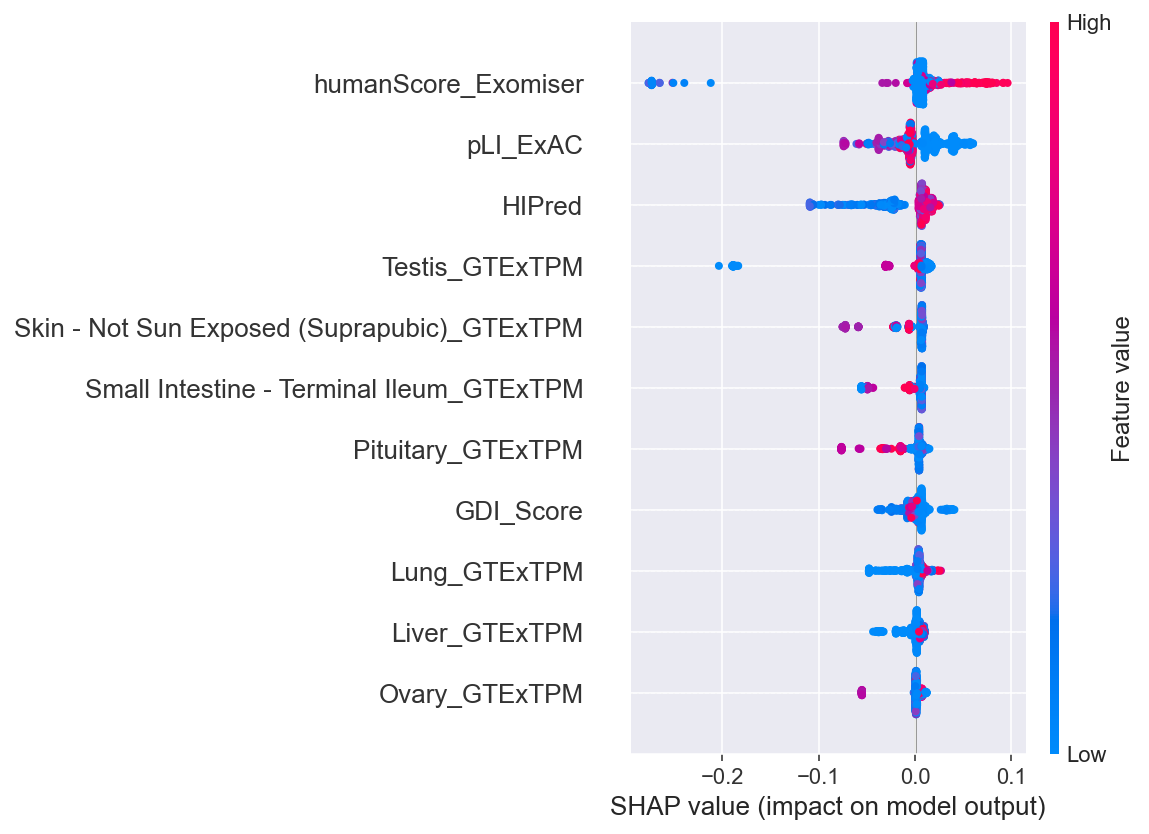

In [28]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values, X)
fig.savefig("shap_summary.png", format="png", dpi=300, bbox_inches="tight")

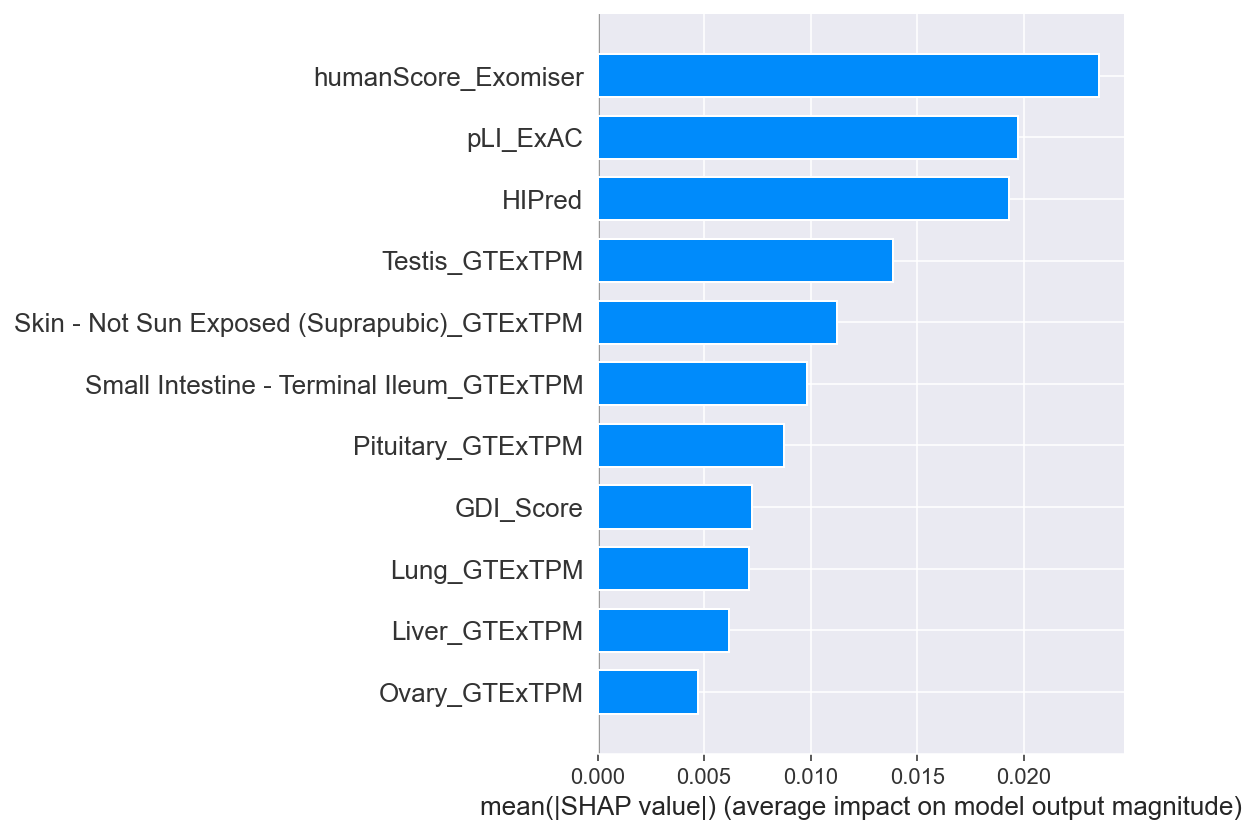

In [29]:
shap.summary_plot(shap_values, X, plot_type="bar")

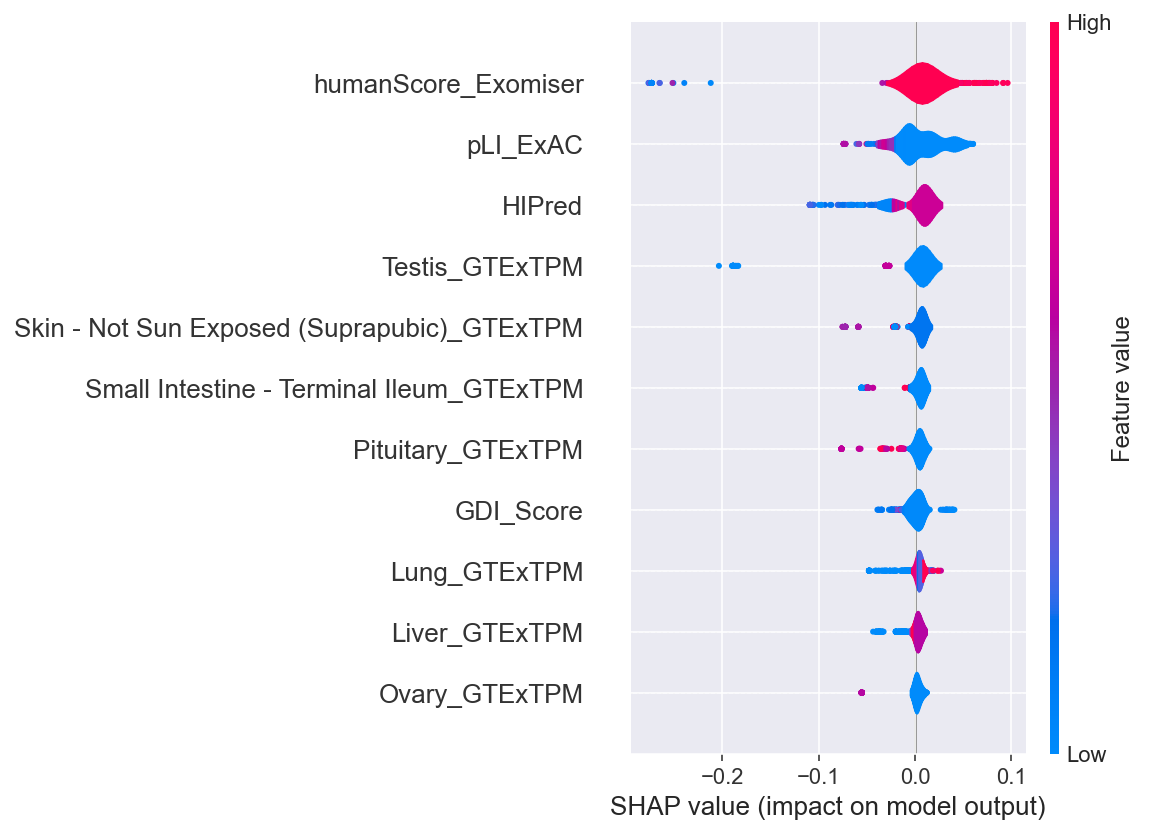

In [30]:
shap.summary_plot(shap_values, X, plot_type="violin", color="coolwarm")

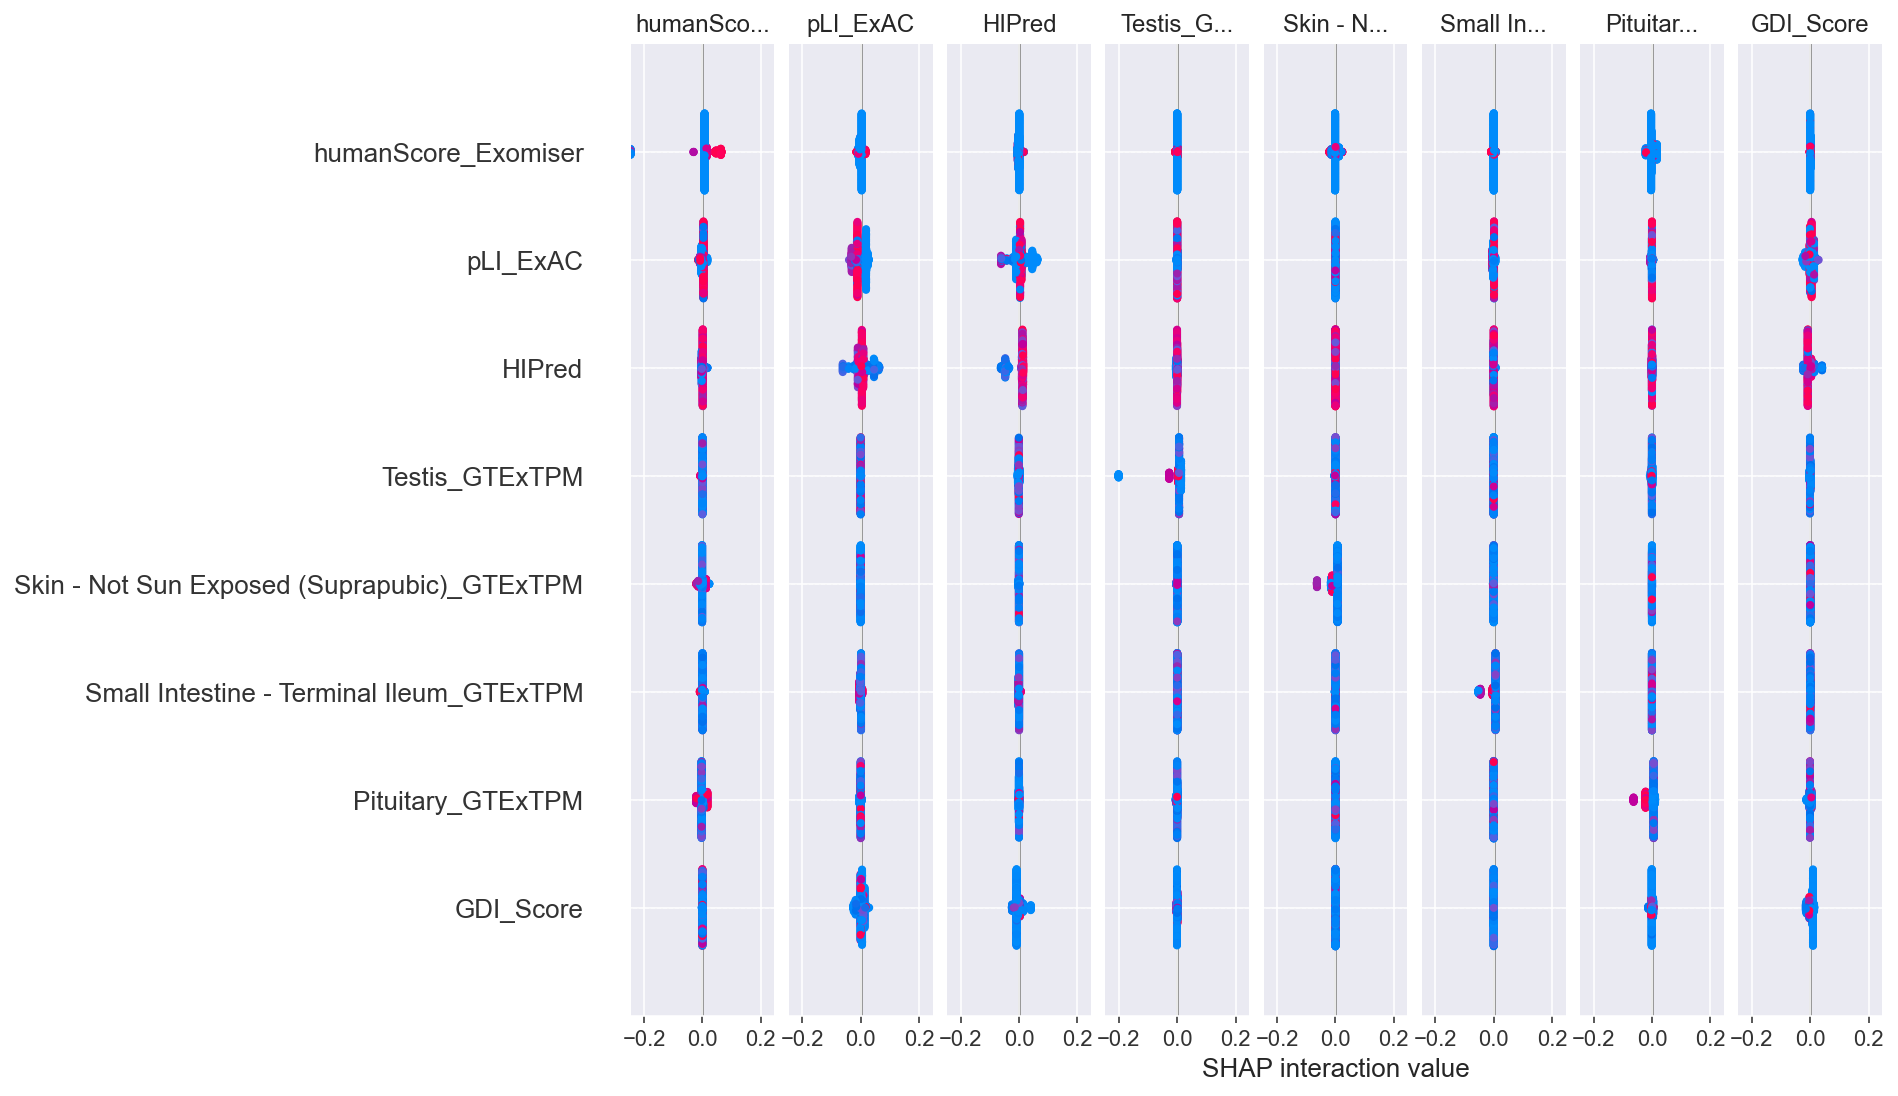

In [31]:
X_interaction = X
shap_interaction_values = shap.TreeExplainer(lgbm).shap_interaction_values(X_interaction)
X_interaction2 = pd.DataFrame(data=X_interaction, columns=X.columns)
shap.summary_plot(shap_interaction_values, X_interaction2, max_display=8)

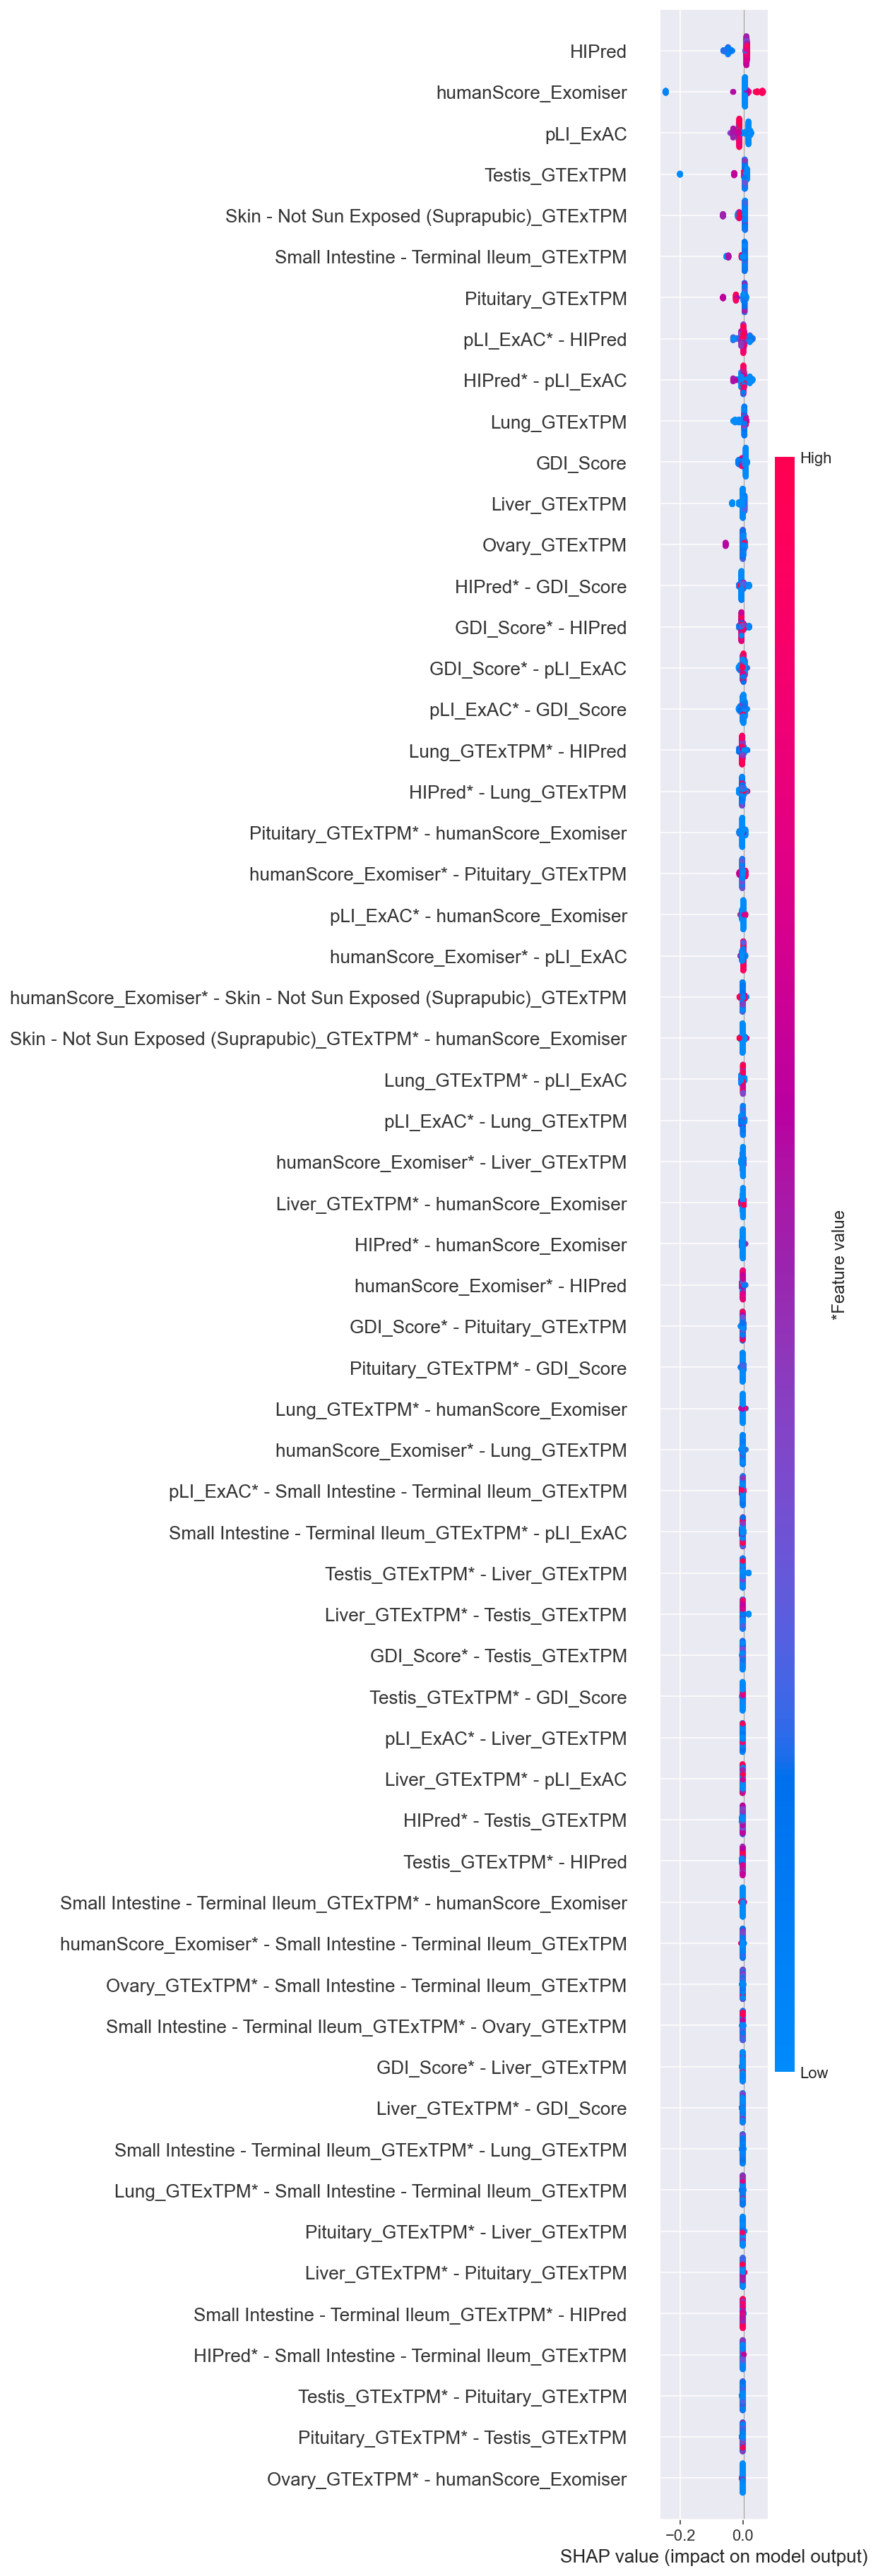

In [32]:
shap.summary_plot(
    shap_interaction_values, X_interaction2, max_display=60, plot_type="compact_dot"
)

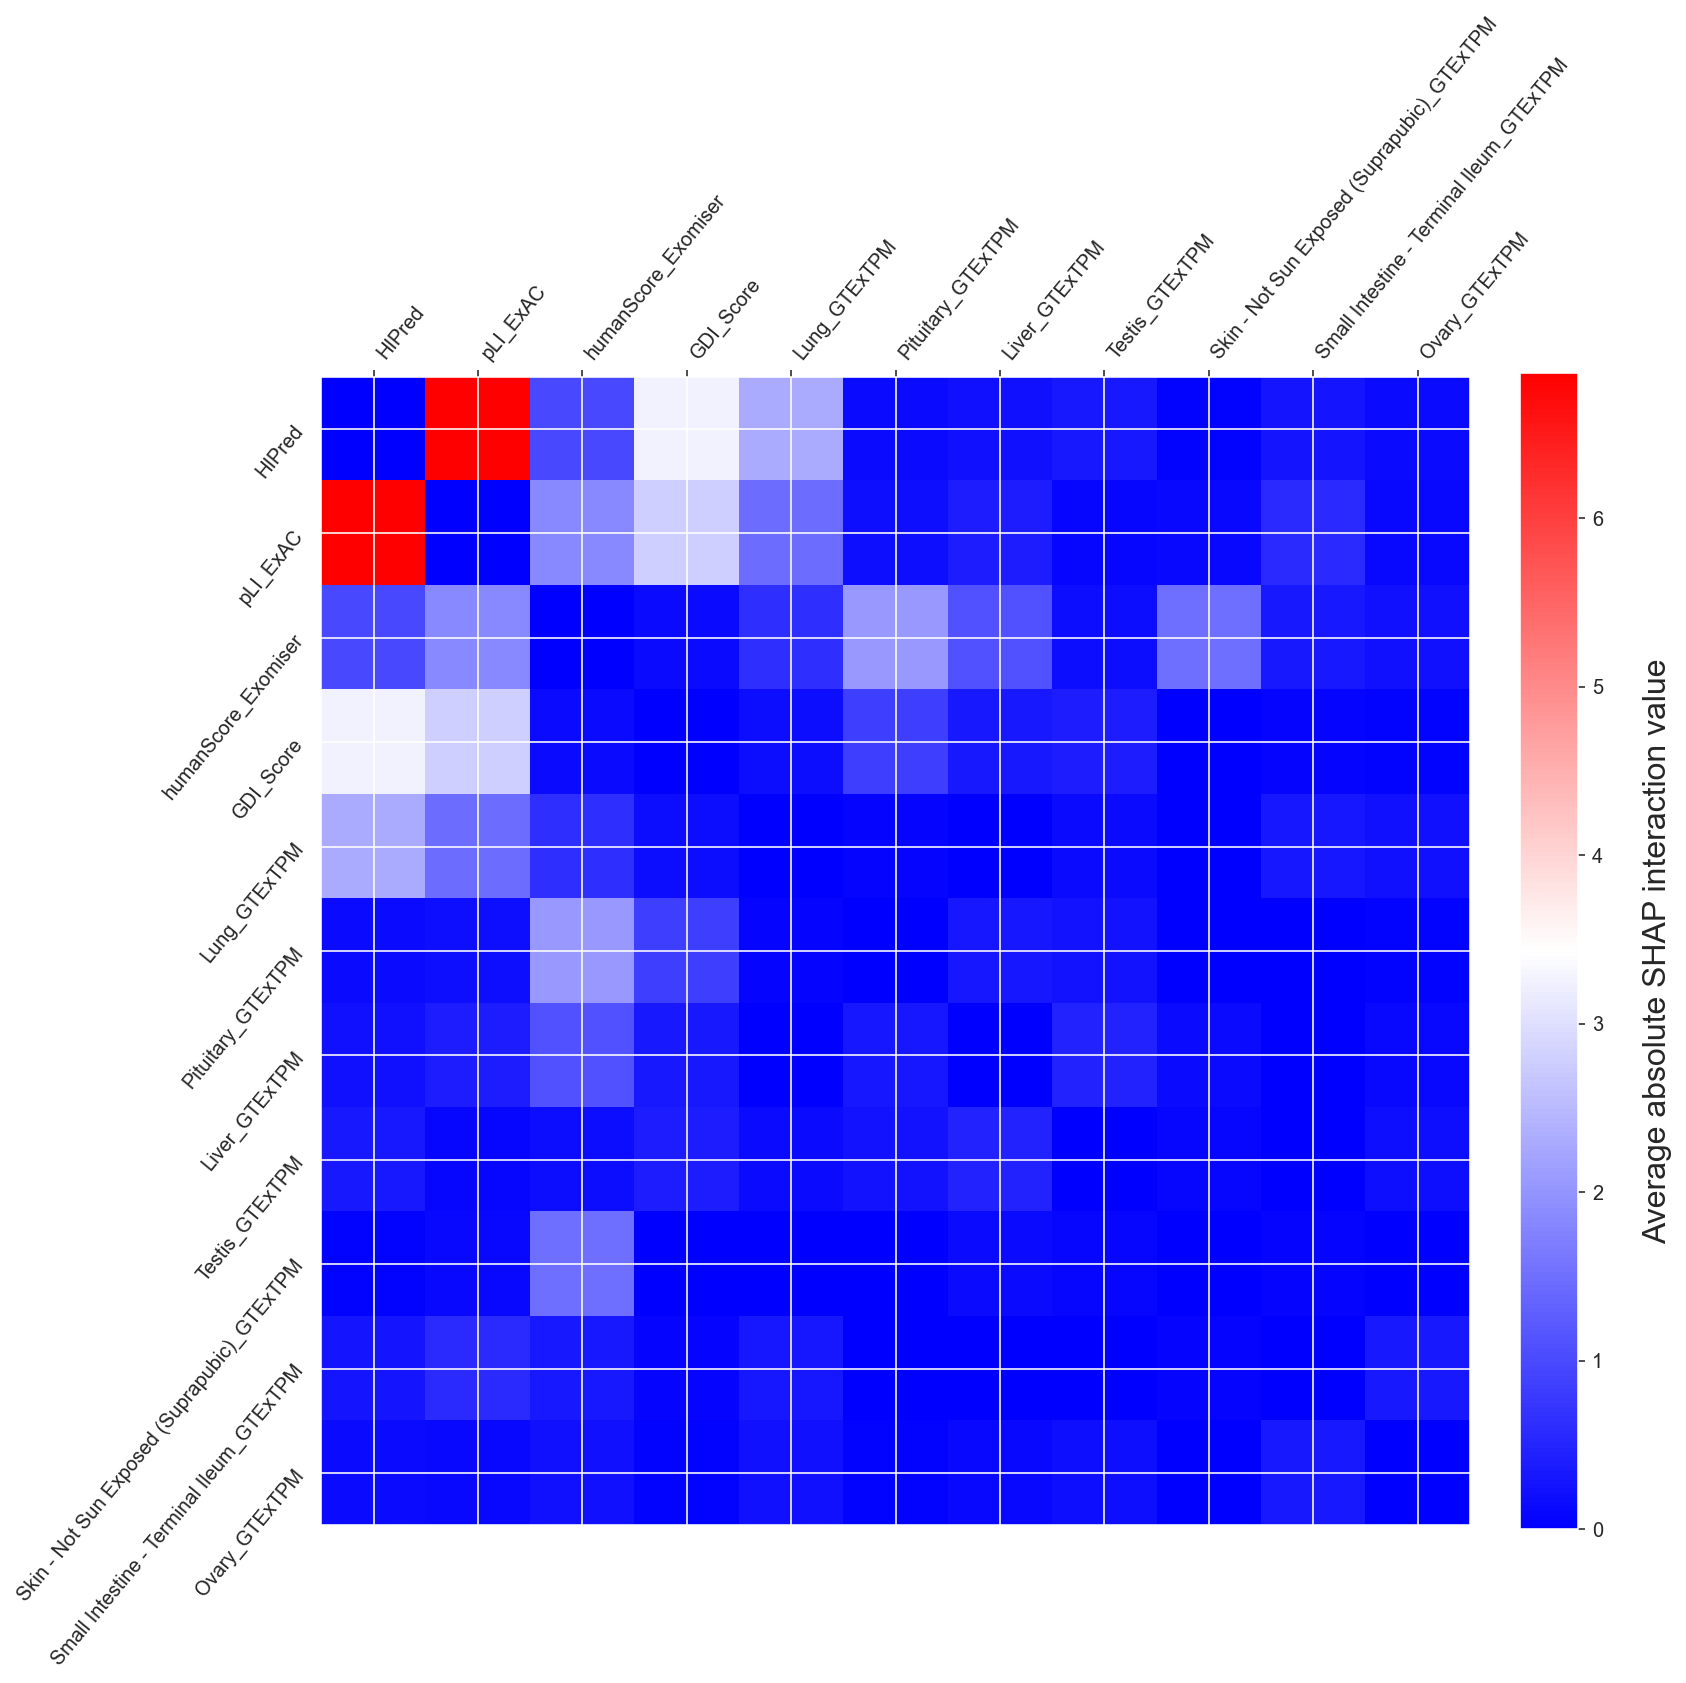

In [33]:
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i, i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds, :][:, inds]


f = plt.figure(figsize=(12, 12))
plt.imshow(
    tmp2, cmap="bwr"
)  # https://matplotlib.org/stable/gallery/color/colormap_reference.html
plt.yticks(
    range(tmp2.shape[0]),
    X_interaction.columns[inds],
    rotation=50.4,
    horizontalalignment="right",
)
plt.xticks(
    range(tmp2.shape[0]),
    X_interaction.columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label("Average absolute SHAP interaction value", size=16, labelpad=20)
plt.rcParams.update({"font.size": 16})
plt.tight_layout()
f.savefig("shap_interactions.png", format="png", dpi=300)


# plt.show()

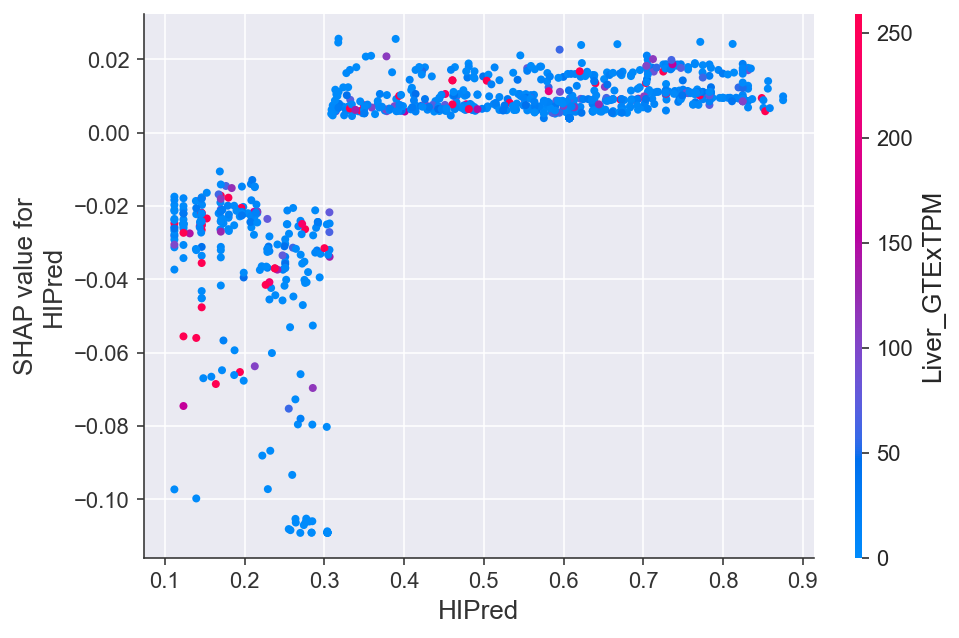

In [34]:
shap.dependence_plot(
    "HIPred", shap_values, X, interaction_index="Liver_GTExTPM"
)

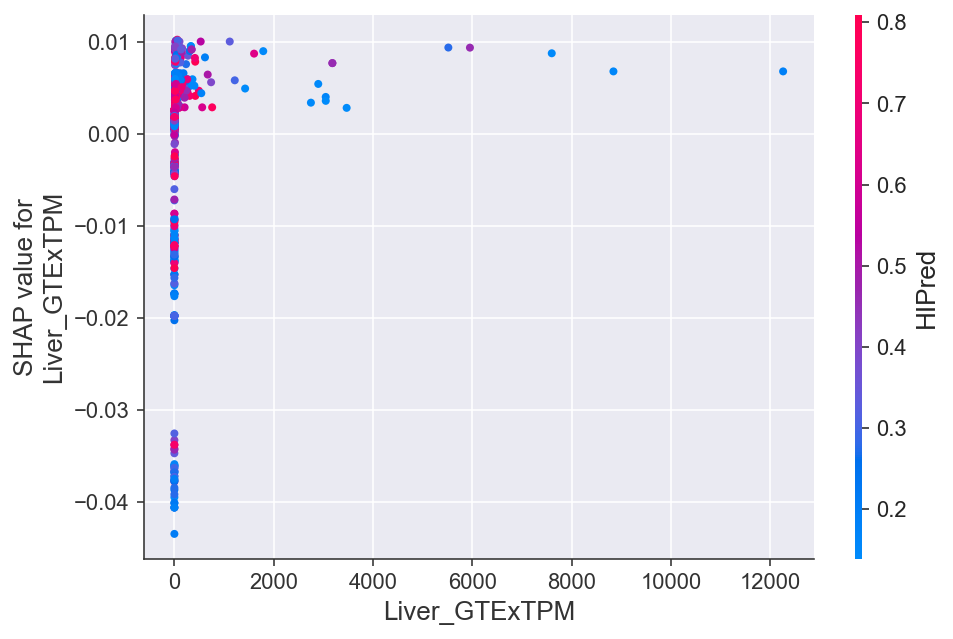

In [35]:
shap.dependence_plot(
    "Liver_GTExTPM", shap_values, X, interaction_index="HIPred"
)

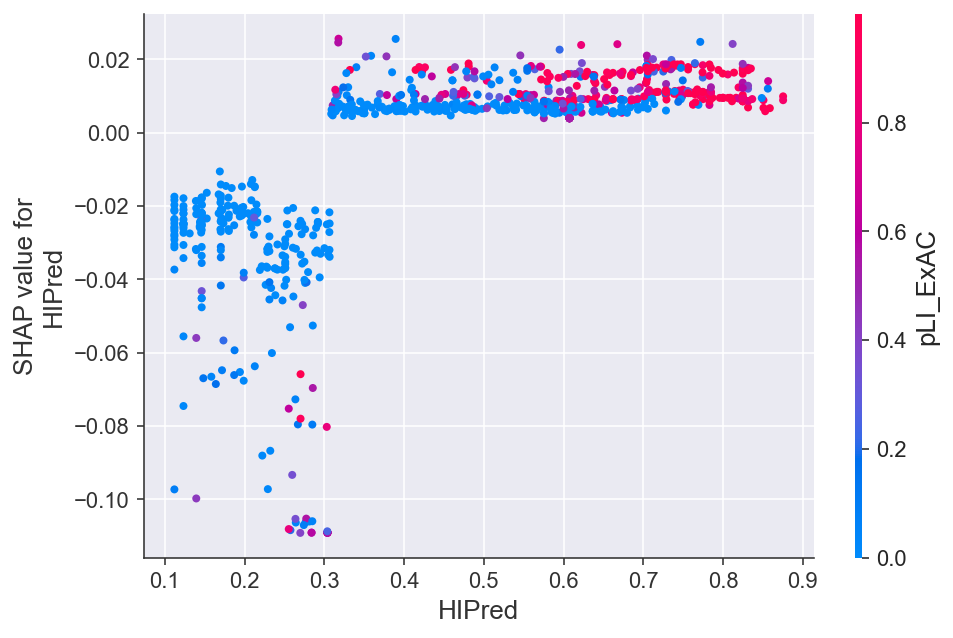

In [36]:
shap.dependence_plot("HIPred", shap_values, X, interaction_index="pLI_ExAC")

In [37]:
expected_value = explainer.expected_value

if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(8)
features = X_test.iloc[select]


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Explainer expected value: 0.7070016902808185


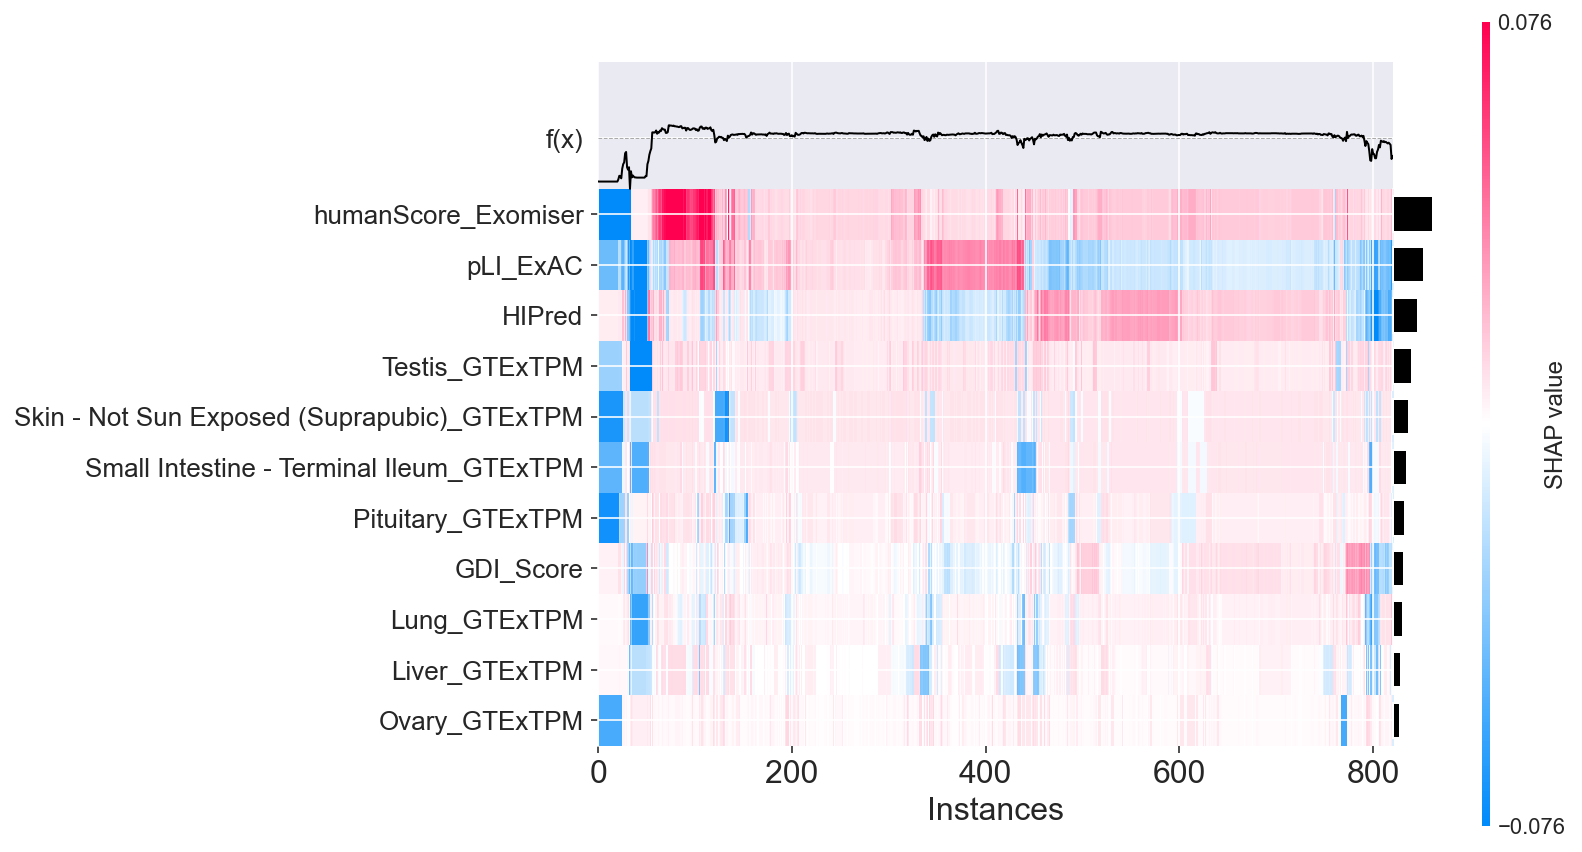

In [101]:
# https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/heatmap.html

shap_values = explainer(X)

fig, ax = plt.subplots()
shap.plots.heatmap(shap_values,max_display=11,show=False)
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(100)
fig.savefig("shap_heatmap.png", format="png", dpi=300, bbox_inches="tight")

In [102]:
select = range(11)
features = X.iloc[select]
features_display = X.loc[features.index]
shap_values = explainer.shap_values(X)

In [104]:
#shap.initjs()
#shap.force_plot(
#    explainer.expected_value, shap_values[:821, :], X.iloc[:821, :], features_display,)

In [94]:
#output_of_force_plot = shap.force_plot(
#    explainer.expected_value,
#    shap_values[:821, :],
#    X.iloc[:821, :],
#    features_display,
#    show=False,
#)
#file = "force_plot.html"
#shap.save_html(file, output_of_force_plot)

### SHAP average measures per gene and per feature:

In [106]:
explainer = shap.Explainer(lgbm, X)
shap_values2 = explainer.shap_values(X)
features = X.columns.values.tolist()

shapdf = pd.DataFrame(data=np.array(shap_values2), columns=features)
shapdf["shap_average"] = shapdf.mean(axis=1)
shapdf

Ovary_GTExTPM  Liver_GTExTPM  humanScore_Exomiser  Testis_GTExTPM  \
0         0.001967       0.010583             0.082866        0.007940   
1         0.003053       0.010793             0.067260        0.012665   
2         0.002768       0.010385             0.082631        0.016537   
3         0.008723       0.010248             0.097076        0.012959   
4         0.003000       0.010385             0.080062        0.013491   
..             ...            ...                  ...             ...   
816       0.005039      -0.020724             0.005304       -0.186588   
817       0.005039      -0.020724             0.005304       -0.186588   
818       0.005039      -0.018062             0.005304       -0.186903   
819       0.005039      -0.020724             0.005304       -0.186588   
820       0.005039      -0.020724             0.005304       -0.186588   

     Small Intestine - Terminal Ileum_GTExTPM  \
0                                    0.007535   
1                                    0.008580   
2                                    0.011571   
3                                    0.006735   
4                                    0.007566   
..                                        ...   
816                                 -0.051883   
817                                 -0.051883   
818                                 -0.051883   
819                                 -0.051883   
820                                 -0.051883   

     Skin - Not Sun Exposed (Suprapubic)_GTExTPM  Pituitary_GTExTPM    HIPred  \
0                                       0.009858           0.010409  0.007286   
1                                       0.009038           0.007232 -0.022997   
2                                       0.009069           0.005070  0.006316   
3                                      -0.001729           0.013677 -0.029092   
4                                       0.009069           0.005967  0.006643   
..                                           ...                ...       ...   
816                                    -0.020224           0.003838 -0.079432   
817                                    -0.020224           0.003838 -0.079432   
818                                    -0.020224           0.004131 -0.075381   
819                                    -0.020224           0.003838 -0.079432   
820                                    -0.020224           0.003838 -0.079432   

     Lung_GTExTPM  GDI_Score  pLI_ExAC  shap_average  
0        0.002473   0.001675  0.024096      0.015153  
1       -0.014023  -0.003480  0.053107      0.011930  
2       -0.009415   0.003936  0.019420      0.014390  
3       -0.013056  -0.007178  0.055544      0.013992  
4       -0.008195  -0.000889  0.020062      0.013378  
..            ...        ...       ...           ...  
816     -0.059721  -0.030663 -0.083225     -0.047116  
817     -0.059721  -0.030663 -0.083225     -0.047116  
818     -0.059721  -0.020882 -0.083571     -0.045650  
819     -0.059721  -0.031470 -0.084901     -0.047342  
820     -0.059721  -0.031470 -0.084901     -0.047342  

[821 rows x 12 columns]

In [107]:
df_d = pd.concat([df_c, shapdf], axis=1)
df_d.to_csv("training_features_shapavg.csv", index=False)
df_d

Gene  lgbm_Score  label_encoded  Ovary_GTExTPM  Liver_GTExTPM  \
0       ABCA1    0.861306            1.0       0.001967       0.010583   
1       ABCG5    0.825847            1.0       0.003053       0.010793   
2     ANGPTL3    0.852904            1.0       0.002768       0.010385   
3       APOA5    0.848525            1.0       0.008723       0.010248   
4        APOB    0.841779            1.0       0.003000       0.010385   
..        ...         ...            ...            ...            ...   
816  USP17L19    0.176337            0.1       0.005039      -0.020724   
817  USP17L20    0.176337            0.1       0.005039      -0.020724   
818  USP17L24    0.192463            0.1       0.005039      -0.018062   
819  USP17L26    0.173854            0.1       0.005039      -0.020724   
820  USP17L29    0.173854            0.1       0.005039      -0.020724   

     humanScore_Exomiser  Testis_GTExTPM  \
0               0.082866        0.007940   
1               0.067260        0.012665   
2               0.082631        0.016537   
3               0.097076        0.012959   
4               0.080062        0.013491   
..                   ...             ...   
816             0.005304       -0.186588   
817             0.005304       -0.186588   
818             0.005304       -0.186903   
819             0.005304       -0.186588   
820             0.005304       -0.186588   

     Small Intestine - Terminal Ileum_GTExTPM  \
0                                    0.007535   
1                                    0.008580   
2                                    0.011571   
3                                    0.006735   
4                                    0.007566   
..                                        ...   
816                                 -0.051883   
817                                 -0.051883   
818                                 -0.051883   
819                                 -0.051883   
820                                 -0.051883   

     Skin - Not Sun Exposed (Suprapubic)_GTExTPM  Pituitary_GTExTPM    HIPred  \
0                                       0.009858           0.010409  0.007286   
1                                       0.009038           0.007232 -0.022997   
2                                       0.009069           0.005070  0.006316   
3                                      -0.001729           0.013677 -0.029092   
4                                       0.009069           0.005967  0.006643   
..                                           ...                ...       ...   
816                                    -0.020224           0.003838 -0.079432   
817                                    -0.020224           0.003838 -0.079432   
818                                    -0.020224           0.004131 -0.075381   
819                                    -0.020224           0.003838 -0.079432   
820                                    -0.020224           0.003838 -0.079432   

     Lung_GTExTPM  GDI_Score  pLI_ExAC  shap_average  
0        0.002473   0.001675  0.024096      0.015153  
1       -0.014023  -0.003480  0.053107      0.011930  
2       -0.009415   0.003936  0.019420      0.014390  
3       -0.013056  -0.007178  0.055544      0.013992  
4       -0.008195  -0.000889  0.020062      0.013378  
..            ...        ...       ...           ...  
816     -0.059721  -0.030663 -0.083225     -0.047116  
817     -0.059721  -0.030663 -0.083225     -0.047116  
818     -0.059721  -0.020882 -0.083571     -0.045650  
819     -0.059721  -0.031470 -0.084901     -0.047342  
820     -0.059721  -0.031470 -0.084901     -0.047342  

[821 rows x 15 columns]

In [108]:
df_e = df_d[["Gene", "lgbm_Score", "shap_average", "label_encoded"]]
df_e.to_csv("training_genes_shapavg.csv", index=False)
df_e

Gene  lgbm_Score  shap_average  label_encoded
0       ABCA1    0.861306      0.015153            1.0
1       ABCG5    0.825847      0.011930            1.0
2     ANGPTL3    0.852904      0.014390            1.0
3       APOA5    0.848525      0.013992            1.0
4        APOB    0.841779      0.013378            1.0
..        ...         ...           ...            ...
816  USP17L19    0.176337     -0.047116            0.1
817  USP17L20    0.176337     -0.047116            0.1
818  USP17L24    0.192463     -0.045650            0.1
819  USP17L26    0.173854     -0.047342            0.1
820  USP17L29    0.173854     -0.047342            0.1

[821 rows x 4 columns]

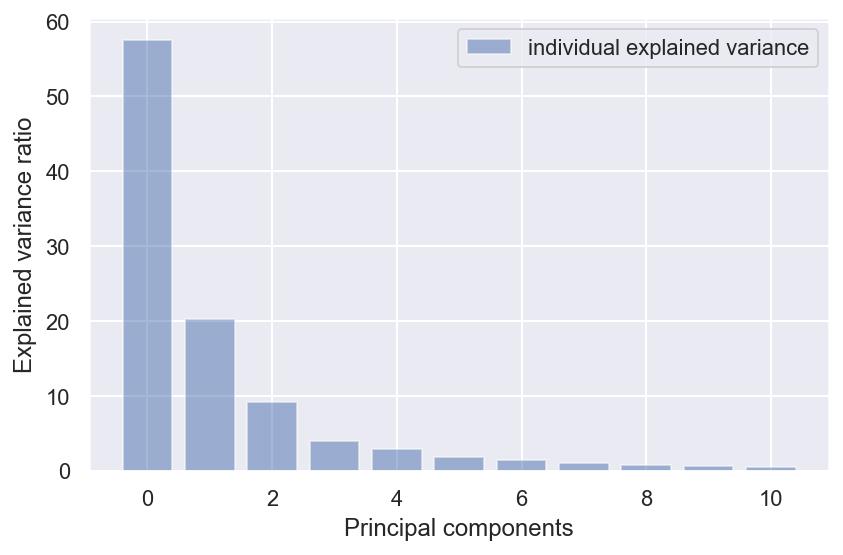

In [111]:
shapdf = pd.DataFrame(data=np.array(shap_values2), columns=features)
X2 = shapdf 
mean_vec = np.mean(X2, axis=0)
cov_mat = (X2 - mean_vec).T.dot((X2 - mean_vec)) / (X2.shape[0] - 1)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

tot = sum(eig_vals)
var_exp = [(i / tot) * 100 for i in sorted(eig_vals, reverse=True)]
len(var_exp)
sns.set(font_scale=1)
plt.figure(figsize=(6, 4))

plt.bar(
    range(11), var_exp, alpha=0.5, align="center", label="individual explained variance"
)
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal components")
plt.legend(loc="best")
plt.tight_layout()

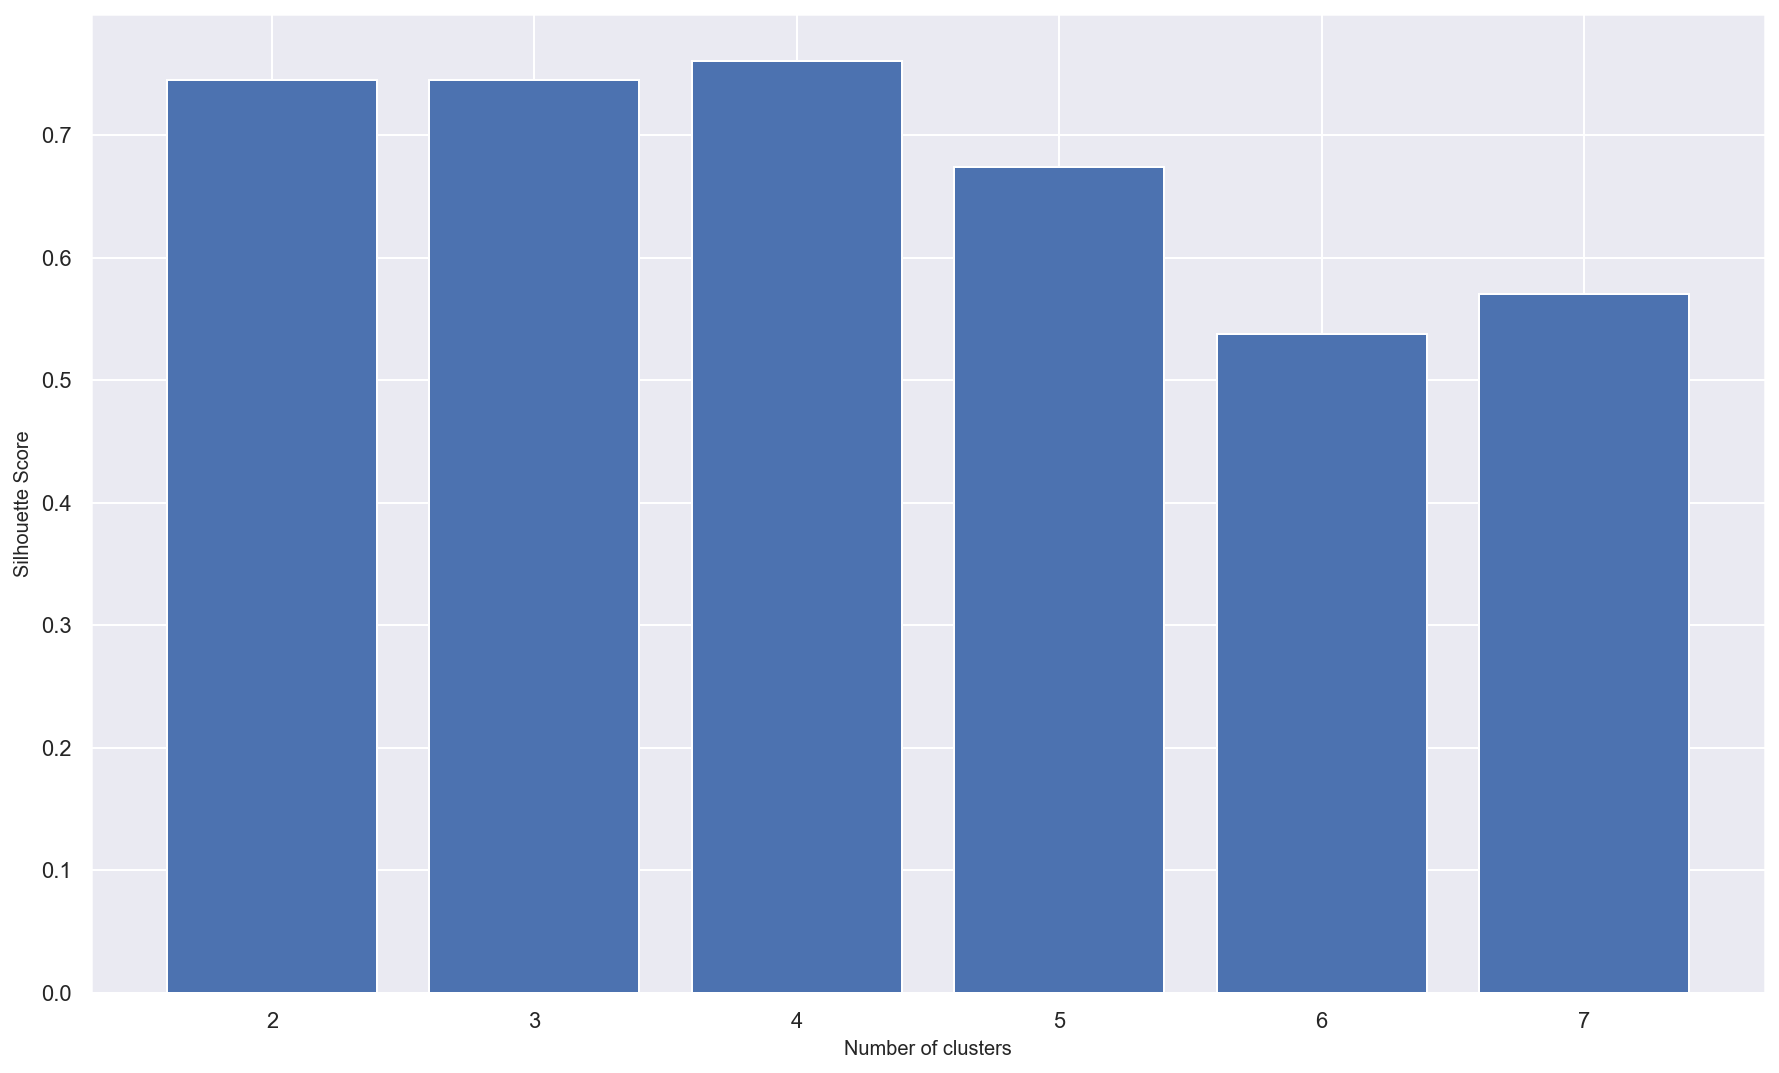

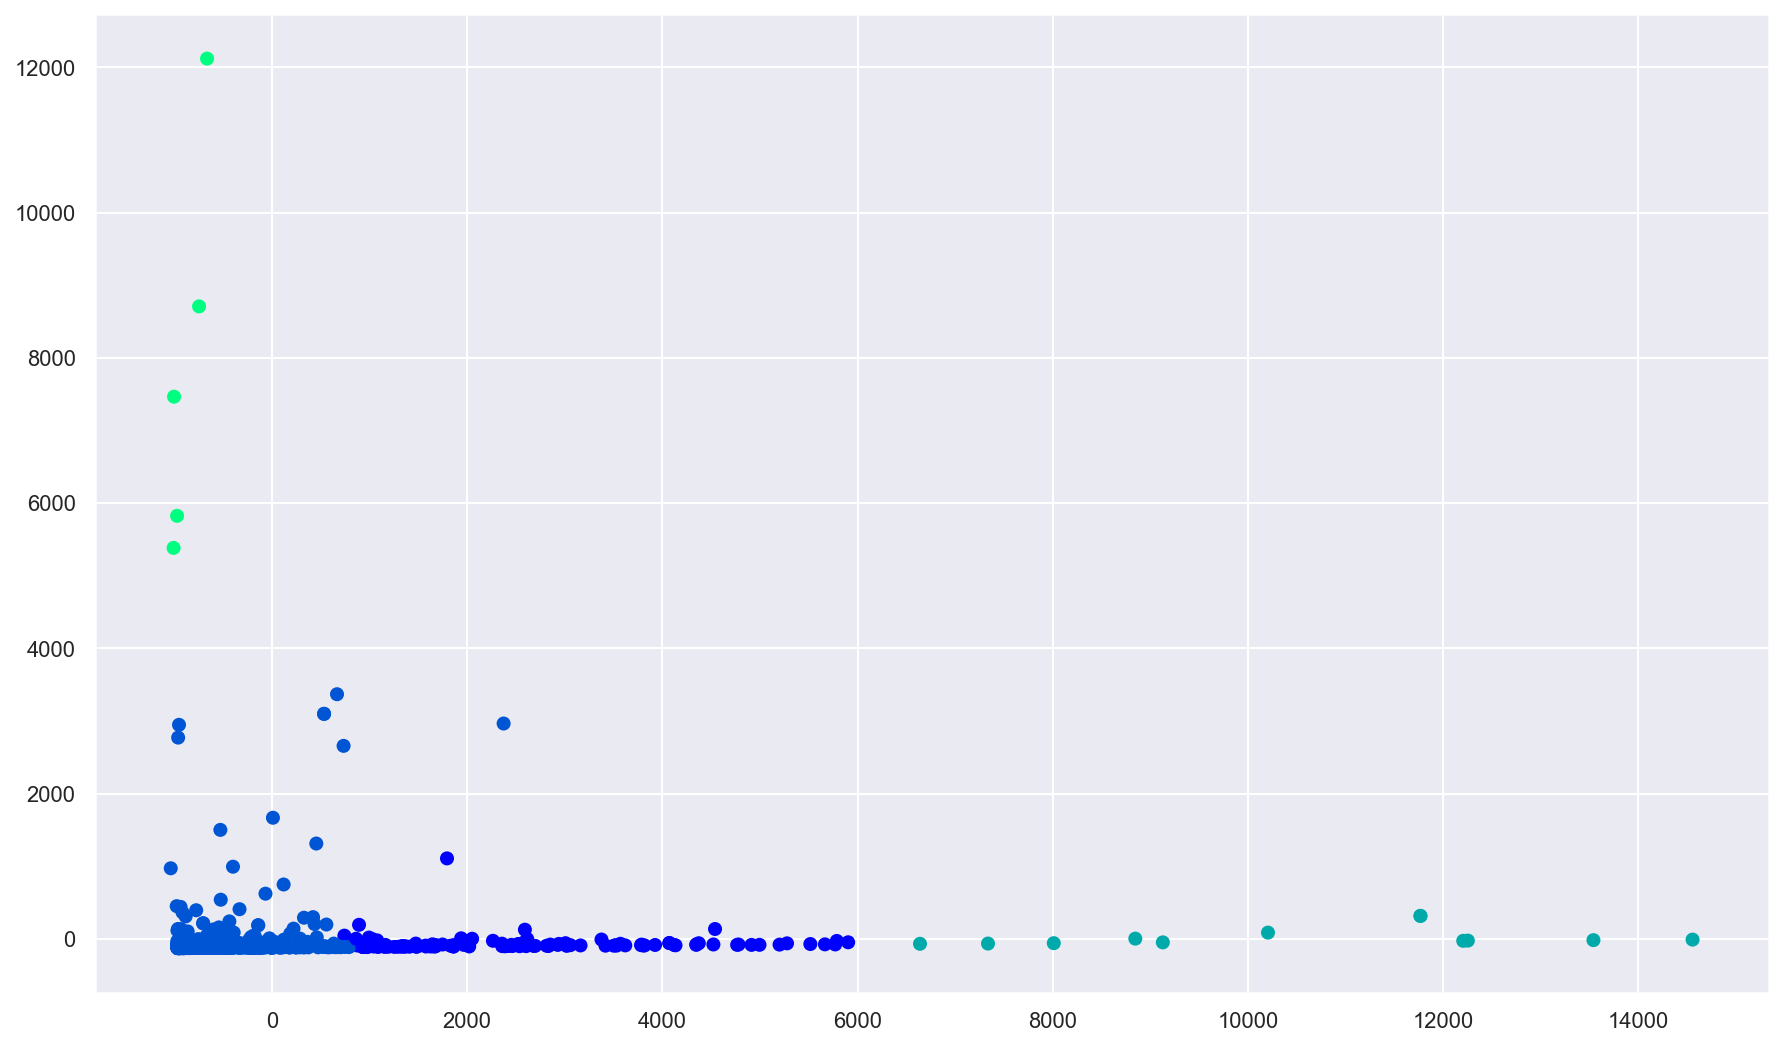

In [118]:
# Reducing the dimensions of the data
pca = PCA(n_components=2)
X_principal = pca.fit_transform(X)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ["P1", "P2"]


silhouette_scores = []

for n_cluster in range(2, 8):
    silhouette_scores.append(
        silhouette_score(
            X_principal,
            AgglomerativeClustering(n_clusters=n_cluster).fit_predict(X_principal),
        )
    )

# Plotting a bar graph to compare the results
k = [2, 3, 4, 5, 6, 7]
plt.bar(k, silhouette_scores)
plt.xlabel("Number of clusters", fontsize=10)
plt.ylabel("Silhouette Score", fontsize=10)
plt.show()


agg = AgglomerativeClustering(n_clusters=4)
agg.fit(X_principal)

sns.set(font_scale=1)
plt.scatter(
    X_principal["P1"],
    X_principal["P2"],
    c=AgglomerativeClustering(n_clusters=4).fit_predict(X_principal),
    cmap=plt.cm.winter,
)
plt.show()

## Decision Plots:
- The plot is centered on the x-axis at explainer.expected_value. All SHAP values are relative to the model's expected value like a linear model's effects are relative to the intercept.
- The y-axis lists the model's features. By default, the features are ordered by descending importance. The importance is calculated over the observations plotted. _This is usually different than the importance ordering for the entire dataset._ In addition to feature importance ordering, the decision plot also supports hierarchical cluster feature ordering and user-defined feature ordering.
- Each observation's prediction is represented by a colored line. At the top of the plot, each line strikes the x-axis at its corresponding observation's predicted value. This value determines the color of the line on a spectrum.
- Moving from the bottom of the plot to the top, SHAP values for each feature are added to the model's base value. This shows how each feature contributes to the overall prediction.
- At the bottom of the plot, the observations converge at explainer.expected_value.

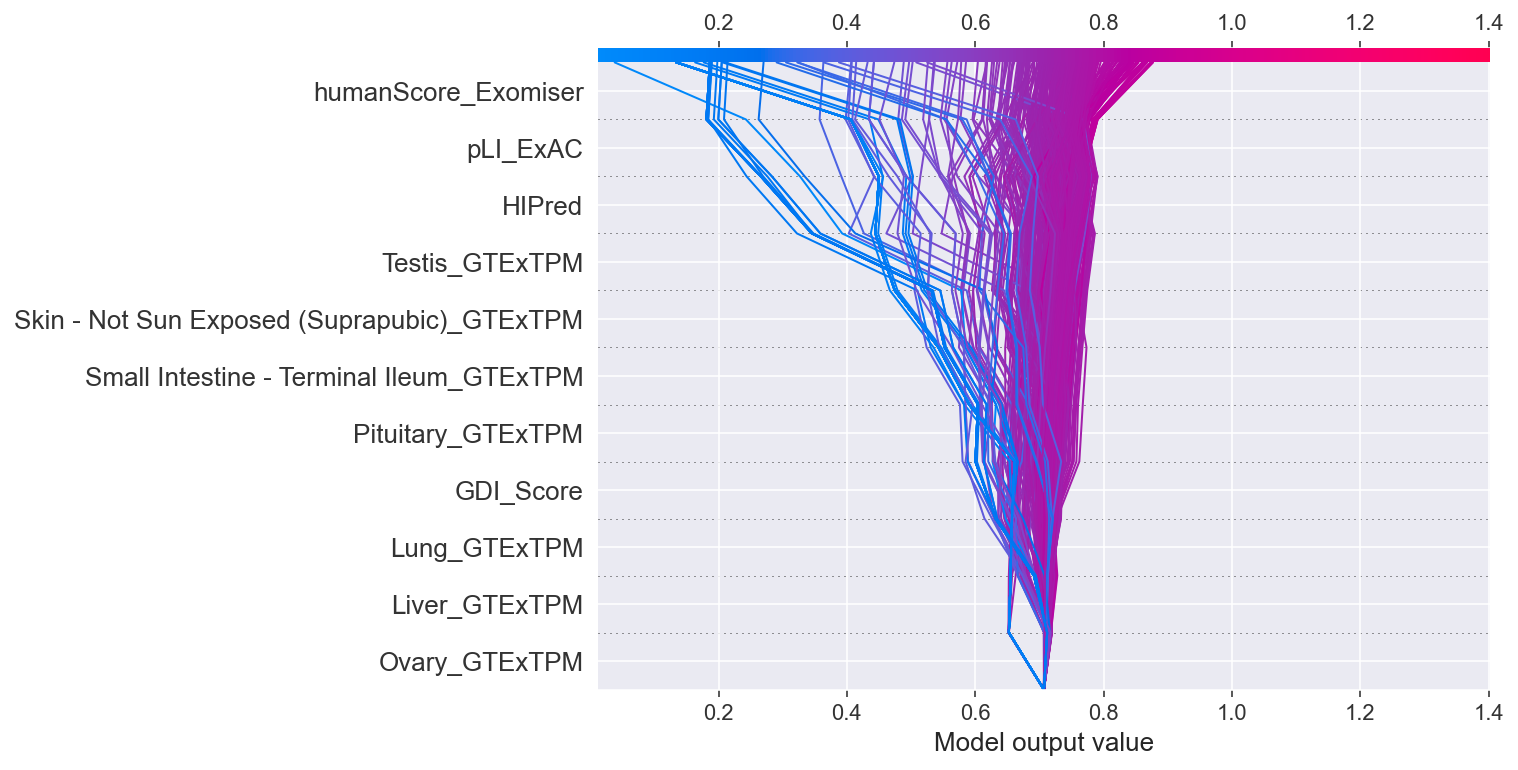

In [56]:
shap.decision_plot(
    expected_value, explainer.shap_values(X), features_display, ignore_warnings=True,
)

In [70]:
X = pd.read_csv("selected_features_training_data.csv", header=0)
X.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X.columns.values
]

In [71]:
y_pred = lgbm.predict(X)

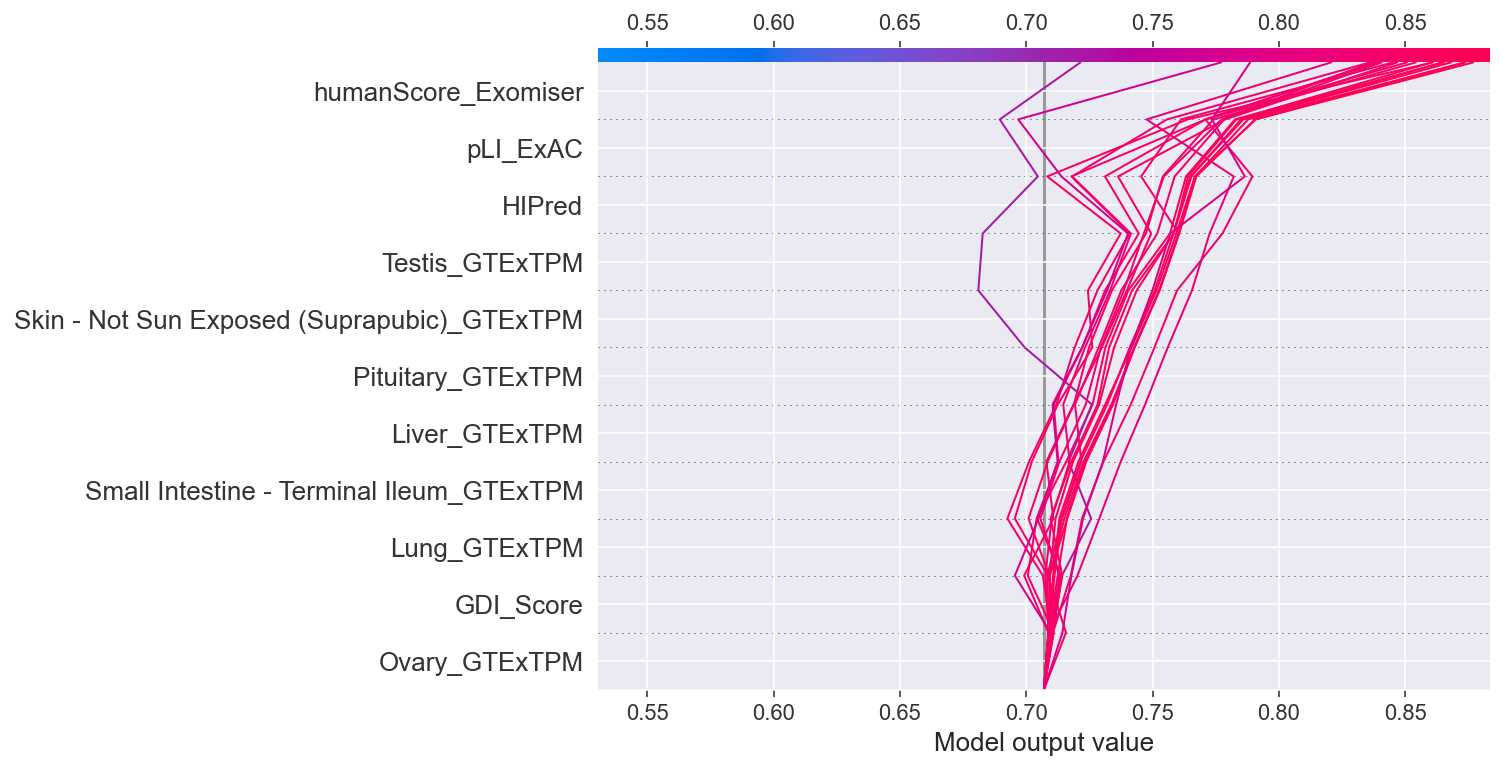

In [59]:
T = X
T = T[(Y == 1)]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)

fig, ax = plt.subplots()
shap.decision_plot(expected_value, sh, T, return_objects=True)
fig.savefig("shap_21genes.png", format="png", dpi=300, bbox_inches="tight")

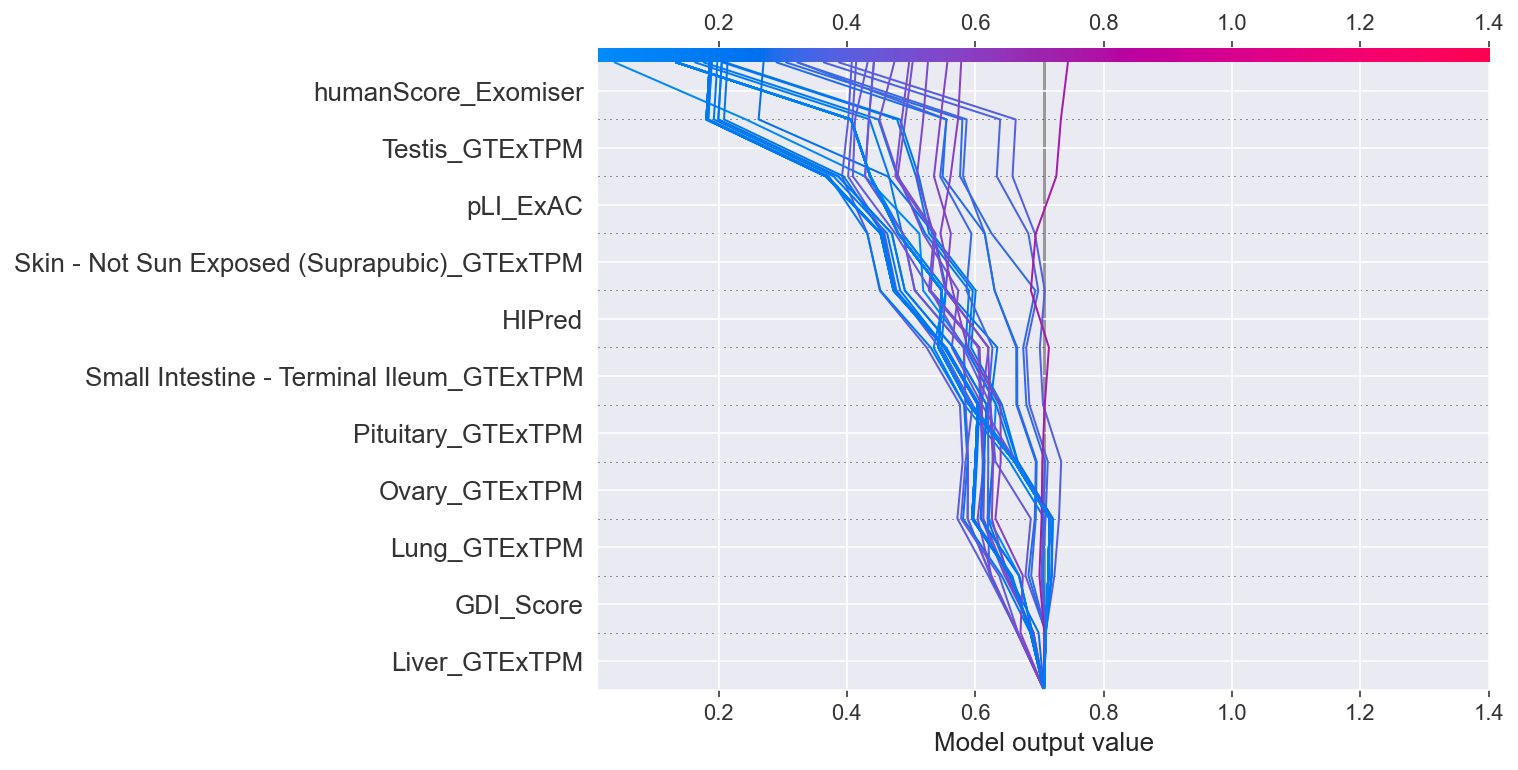

In [61]:
y_pred = lgbm.predict(X)
T = X
T = T[(Y == 0.1)]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)
r = shap.decision_plot(expected_value, sh, T, return_objects=True)

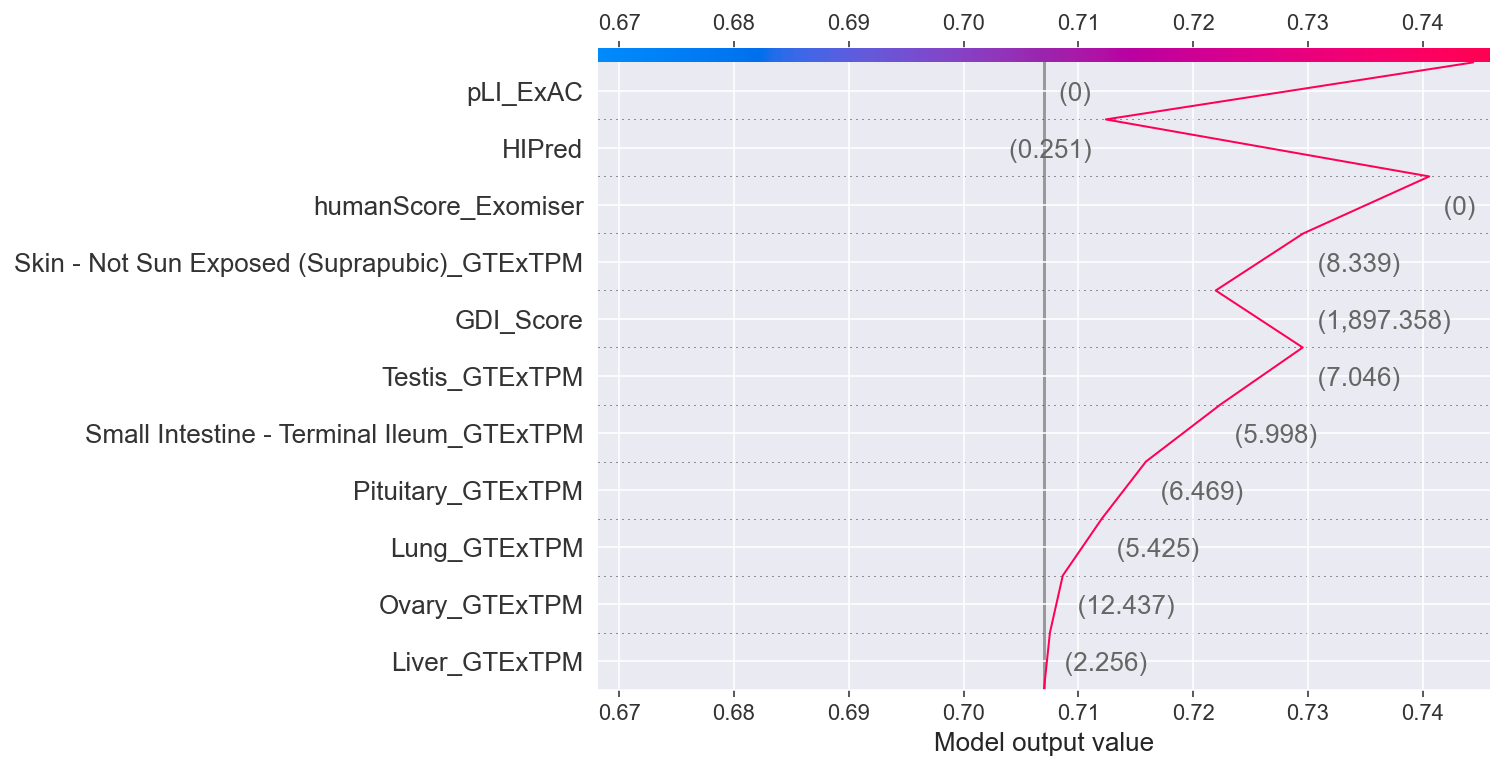

In [72]:
T = X[(y_pred >= 0.7)]
T = T[(Y == 0.1)]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)
r = shap.decision_plot(expected_value, sh, T, return_objects=True)

In [73]:
T

Ovary_GTExTPM  Liver_GTExTPM  humanScore_Exomiser  Testis_GTExTPM  \
813        12.4366        2.25585                  0.0         7.04582   

     Small Intestine - Terminal Ileum_GTExTPM  \
813                                   5.99772   

     Skin - Not Sun Exposed (Suprapubic)_GTExTPM  Pituitary_GTExTPM    HIPred  \
813                                      8.33871            6.46859  0.250911   

     Lung_GTExTPM   GDI_Score  pLI_ExAC  
813       5.42479  1897.35826  0.000185

In [74]:
X = pd.read_csv("selected_features_training_data.csv", header=0)
X.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X.columns.values
]
df_gene = data[["Gene"]]

X = pd.concat([df_gene, X], axis=1)

X = X.set_index("Gene")

X.iloc[813]

Ovary_GTExTPM                                    12.436600
Liver_GTExTPM                                     2.255850
humanScore_Exomiser                               0.000000
Testis_GTExTPM                                    7.045820
Small Intestine - Terminal Ileum_GTExTPM          5.997720
Skin - Not Sun Exposed (Suprapubic)_GTExTPM       8.338710
Pituitary_GTExTPM                                 6.468590
HIPred                                            0.250911
Lung_GTExTPM                                      5.424790
GDI_Score                                      1897.358260
pLI_ExAC                                          0.000185
Name: TAMM41, dtype: float64

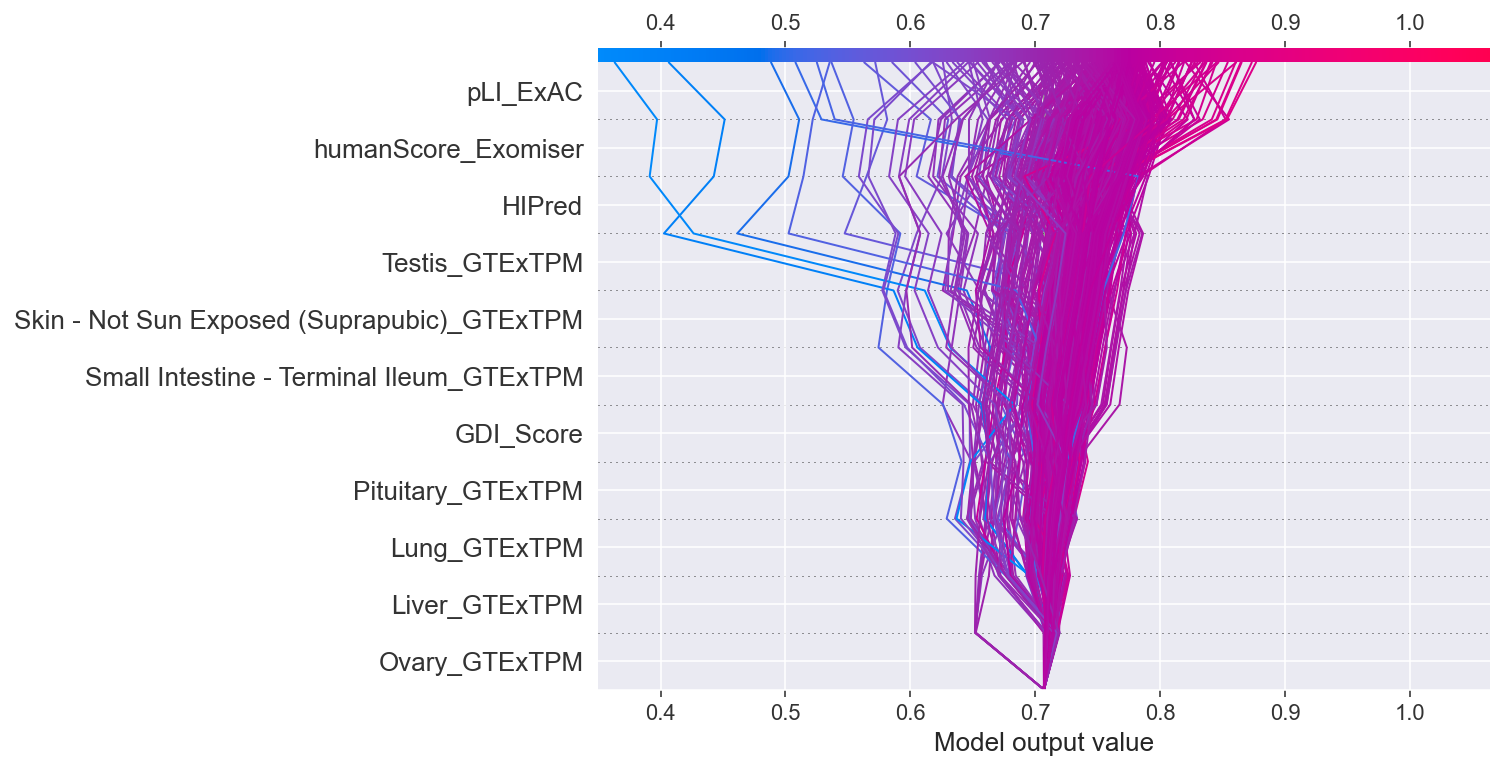

In [77]:
X = pd.read_csv("selected_features_training_data.csv", header=0)
X.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X.columns.values
]
y_pred = lgbm.predict(X)
T = X
T = T[(Y == 0.75)]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)
r = shap.decision_plot(expected_value, sh, T, return_objects=True)

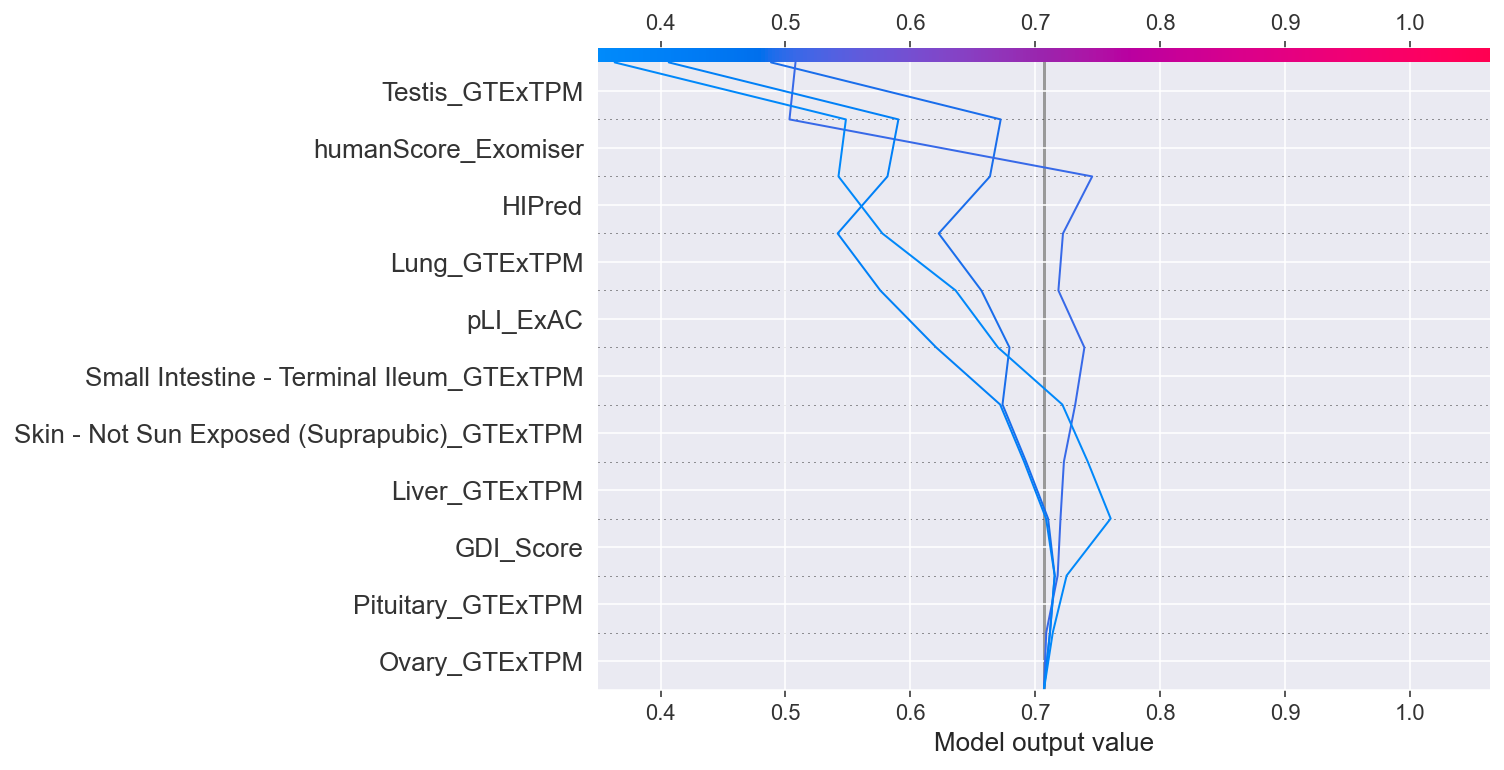

In [78]:
T = X[(y_pred <= 0.5)]
T = T[(Y == 0.75)]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)
r = shap.decision_plot(expected_value, sh, T, return_objects=True)

In [79]:
print(T)

     Ovary_GTExTPM  Liver_GTExTPM  humanScore_Exomiser  Testis_GTExTPM  \
334         0.0000          0.000             0.000000        0.013263   
388        48.2932         11.746             0.029604       77.083100   
438         0.0000          0.000             0.000000        0.000000   
548         0.0000          0.000             0.000000        0.000000   

     Small Intestine - Terminal Ileum_GTExTPM  \
334                                  0.049364   
388                                 31.356400   
438                                  0.000000   
548                                  0.000000   

     Skin - Not Sun Exposed (Suprapubic)_GTExTPM  Pituitary_GTExTPM    HIPred  \
334                                       0.0000             0.0000  0.317764   
388                                      39.8376            40.9615  0.571837   
438                                       0.0000             0.0000  0.317404   
548                                       0.0000           

In [82]:
X = pd.read_csv("selected_features_training_data.csv", header=0)
X.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X.columns.values
]
df_gene = data[["Gene"]]

X = pd.concat([df_gene, X], axis=1)

X = X.set_index("Gene")

X.iloc[[334, 388, 438,548]]

Ovary_GTExTPM  Liver_GTExTPM  humanScore_Exomiser  Testis_GTExTPM  \
Gene                                                                        
GPR42          0.0000          0.000             0.000000        0.013263   
KMT2B         48.2932         11.746             0.029604       77.083100   
MIR33A         0.0000          0.000             0.000000        0.000000   
PMCH           0.0000          0.000             0.000000        0.000000   

        Small Intestine - Terminal Ileum_GTExTPM  \
Gene                                               
GPR42                                   0.049364   
KMT2B                                  31.356400   
MIR33A                                  0.000000   
PMCH                                    0.000000   

        Skin - Not Sun Exposed (Suprapubic)_GTExTPM  Pituitary_GTExTPM  \
Gene                                                                     
GPR42                                        0.0000             0.0000   
KMT2B                                       39.8376            40.9615   
MIR33A                                       0.0000             0.0000   
PMCH                                         0.0000             0.0000   

          HIPred  Lung_GTExTPM    GDI_Score  pLI_ExAC  
Gene                                                   
GPR42   0.317764        0.0000   638.823660  0.659178  
KMT2B   0.571837       35.9523  1636.686680  1.000000  
MIR33A  0.317404        0.0000   734.974868  0.569230  
PMCH    0.187377        0.0000     6.881980  0.115286

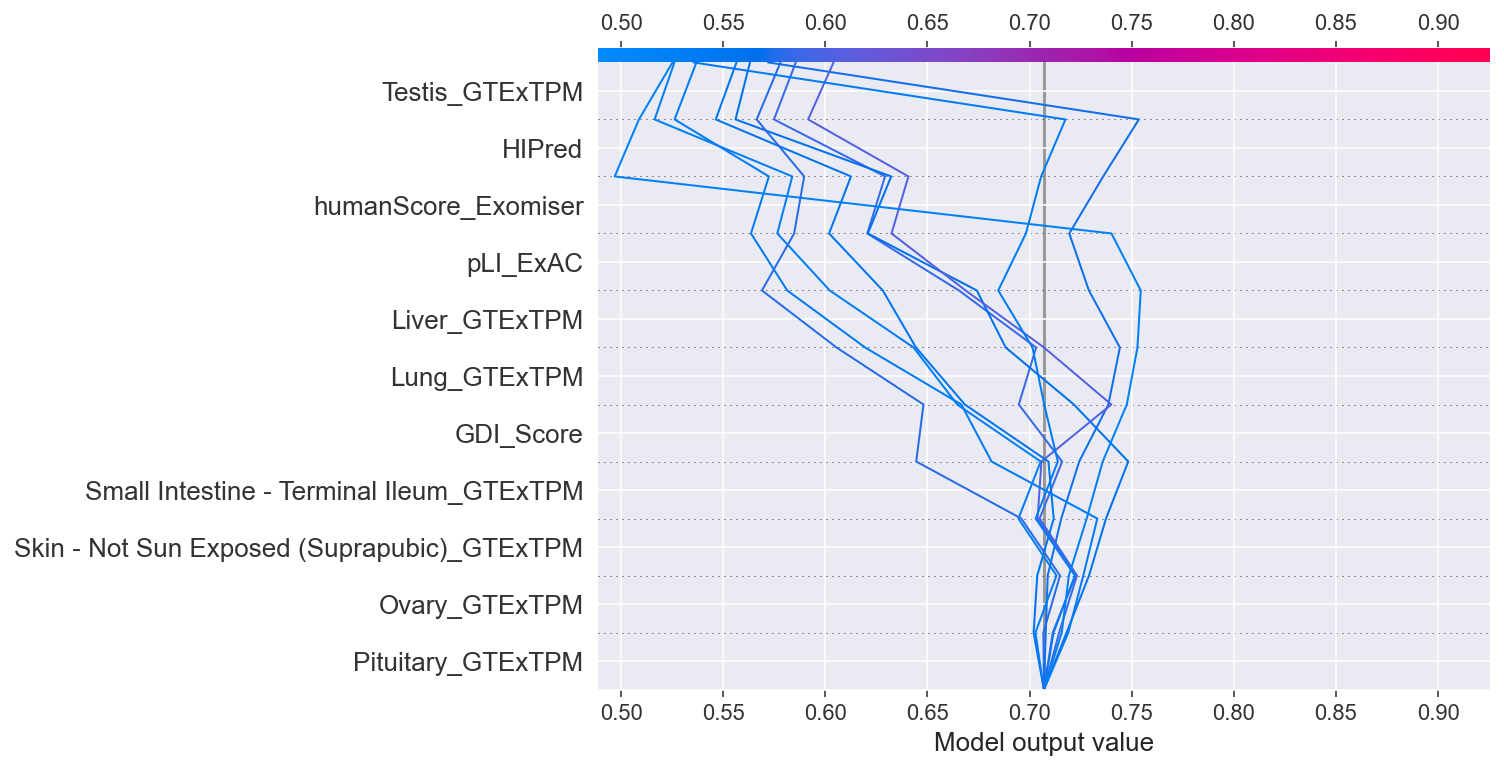

In [83]:
y_pred = lgbm.predict(X)

T = X[(y_pred >= 0.5) & (y_pred <= 0.6)]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)
r = shap.decision_plot(expected_value, sh, T, return_objects=True)

In [84]:
predictions = list(lgbm.predict(X))

output = pd.Series(data=predictions, index=X.index, name="lgbm_Score")

output = output.to_frame()
output.reset_index(level=0, inplace=True)

output

df_b = data[["label_encoded"]]

df_c = pd.concat([output, df_b], axis=1)
df_c

Gene  lgbm_Score  label_encoded
0       ABCA1    0.861306            1.0
1       ABCG5    0.825847            1.0
2     ANGPTL3    0.852904            1.0
3       APOA5    0.848525            1.0
4        APOB    0.841779            1.0
..        ...         ...            ...
816  USP17L19    0.176337            0.1
817  USP17L20    0.176337            0.1
818  USP17L24    0.192463            0.1
819  USP17L26    0.173854            0.1
820  USP17L29    0.173854            0.1

[821 rows x 3 columns]

In [85]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(lgbm)
    shap_values_Model = explainerModel.shap_values(X)
    p = shap.force_plot(
        explainerModel.expected_value,
        shap_values_Model[j],
        X.iloc[[j]],
        feature_names=X.columns,
    )
    return p


# fig, ax = plt.subplots()
shap_plot(813)
# fig.savefig('bdnf_force.png', format='png', dpi=300, bbox_inches = "tight")

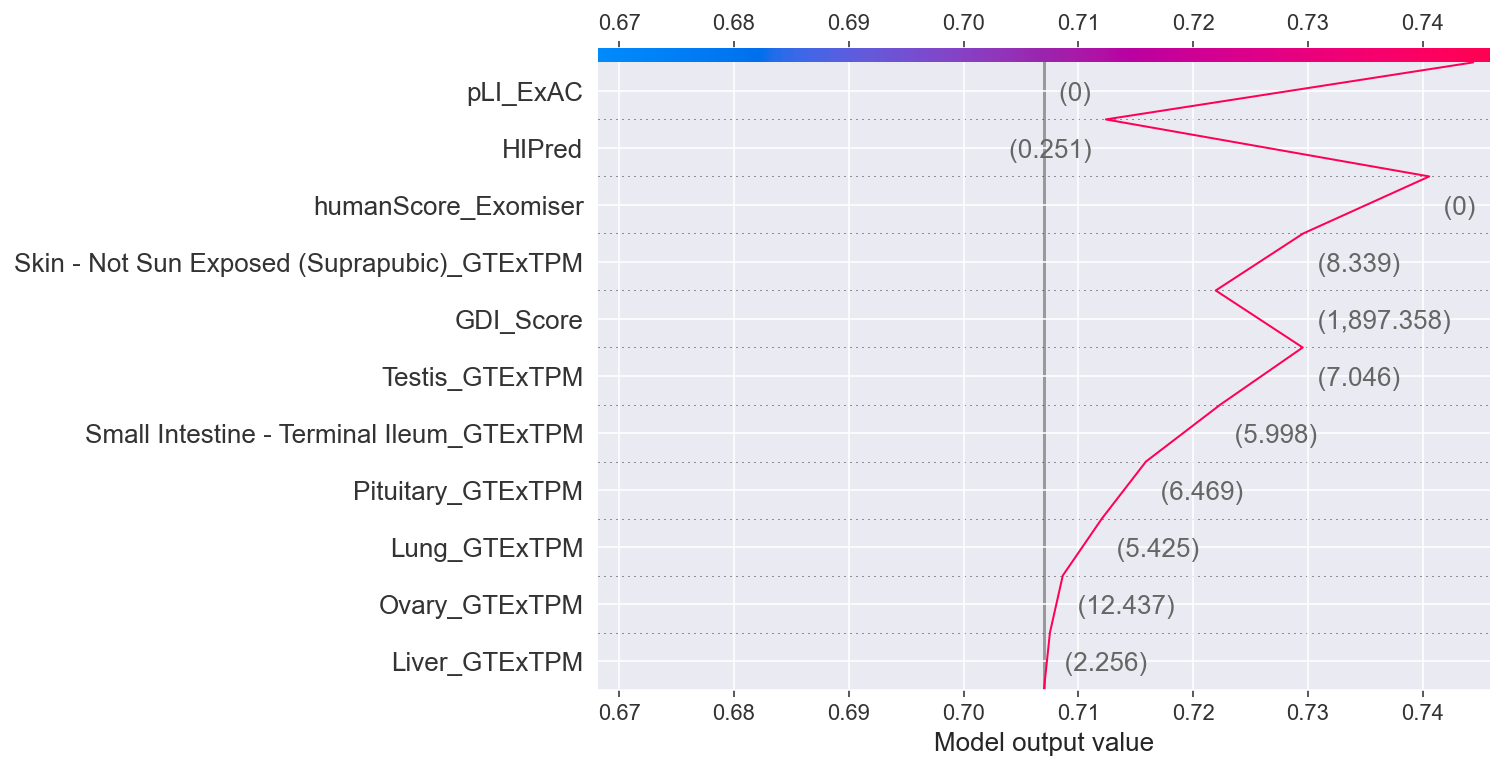

In [86]:
# EDNRA
shap.decision_plot(
    expected_value,
    explainer.shap_values(X.iloc[[813]]),
    X.iloc[813],
    list(features_display),
)

## Unknown Gene Prediction

In [54]:
dataset_unknown = pd.read_csv("predicted_data.txt", sep="\t")
dataset_unknown = dataset_unknown.rename({"IPA_BP": "IPA_BP_annotation"}, axis=1)
df2 = dataset_unknown[
    [
        "SDI",
        "Liver_GTExTPM",
        "Cells - EBV-transformed lymphocytes_GTExTPM",
        "Pituitary_GTExTPM",
        "pLI_ExAC",
        "mousescore_Exomiser",
        "HIPred",
        "IPA_BP_annotation",
    ]
]

df2.shape

(1804, 8)

In [55]:
imputer = MissForest(random_state=seed)
df3 = imputer.fit_transform(df2)

Iteration: 0
Iteration: 1
Iteration: 2


In [56]:
X2 = pd.DataFrame(df3, index=df2.index, columns=df2.columns)

X2.shape

(1804, 8)

In [57]:
model = lgbm
model.fit(X, Y)
predictions = list(model.predict(X2))

output = pd.Series(data=predictions, index=dataset_unknown.index, name="lgbm_Score")

df_total = pd.concat([dataset_unknown, output], axis=1)

In [58]:
df_total.nlargest(10, "lgbm_Score", keep="last")

Gene  REVEL.max  MetaSVM_rankscore.max  MetaLR_rankscore.max  \
331    COL15A1      0.412                  0.876                 0.880   
1505     SMOC2        NaN                    NaN                   NaN   
827       MLIP      0.000                  0.354                 0.075   
1444      SGCD        NaN                    NaN                   NaN   
306      CHRM2        NaN                    NaN                   NaN   
329       COG2      0.110                  0.339                 0.006   
463       ELK3        NaN                    NaN                   NaN   
1513     SNTB2      0.106                    NaN                   NaN   
114   ARHGEF26      0.456                  0.792                 0.653   
1171     PTPN3      0.354                  0.331                 0.000   

      MCAP.max  wgEncodeBroadHmmHuvecHMM.count  betamax  logpval_gwascatalog  \
331        NaN                              33  -0.3010             23.30103   
1505       NaN                             230  -0.4184             22.30103   
827        NaN                              10  -0.1964             13.00000   
1444       NaN                             280   0.2110             10.00000   
306        NaN                             494   0.4323             12.00000   
329        NaN                             796  -0.3285              5.09691   
463        NaN                              21  -0.4724             10.69897   
1513       NaN                              15  -0.1717             12.30103   
114        NaN                             222   0.6269             10.00000   
1171       NaN                              25  -0.2487              9.39794   

      Adipose - Subcutaneous_GTExTPM  Adipose - Visceral (Omentum)_GTExTPM  \
331                       126.192000                             75.095400   
1505                       75.416100                             71.252200   
827                         0.673251                              0.293427   
1444                        3.075140                              2.000780   
306                         0.004196                              0.023050   
329                        14.409000                             11.299500   
463                        58.474600                             48.517600   
1513                       22.574200                             16.015500   
114                        10.389700                              7.280710   
1171                        3.491070                              3.822930   

      ...  MetaLR_rankscore  MetaSVM_rankscore  MutationAssessor_rankscore  \
331   ...               NaN                NaN                         NaN   
1505  ...               NaN                NaN                         NaN   
827   ...           0.48084            0.63282                     0.97045   
1444  ...               NaN                NaN                         NaN   
306   ...               NaN                NaN                         NaN   
329   ...               NaN                NaN                         NaN   
463   ...           0.20672            0.30227                         NaN   
1513  ...           0.96265            0.94265                     0.82220   
114   ...               NaN                NaN                         NaN   
1171  ...           0.63929            0.64722                     0.50145   

      REVEL_score  fathmm-MKL_coding_score  integrated_fitCons_rankscore  \
331           NaN                      NaN                           NaN   
1505          NaN                      NaN                           NaN   
827         0.508                  0.98749                       0.97801   
1444          NaN                      NaN                           NaN   
306           NaN                      NaN                           NaN   
329           NaN                      NaN                           NaN   
463         0.006                  0.01204                      

In [59]:
df_file = df_total[["Gene", "lgbm_Score"]]
df_file = df_file.nlargest(1804, "lgbm_Score", keep="last")

### Model Prediction Distribution:

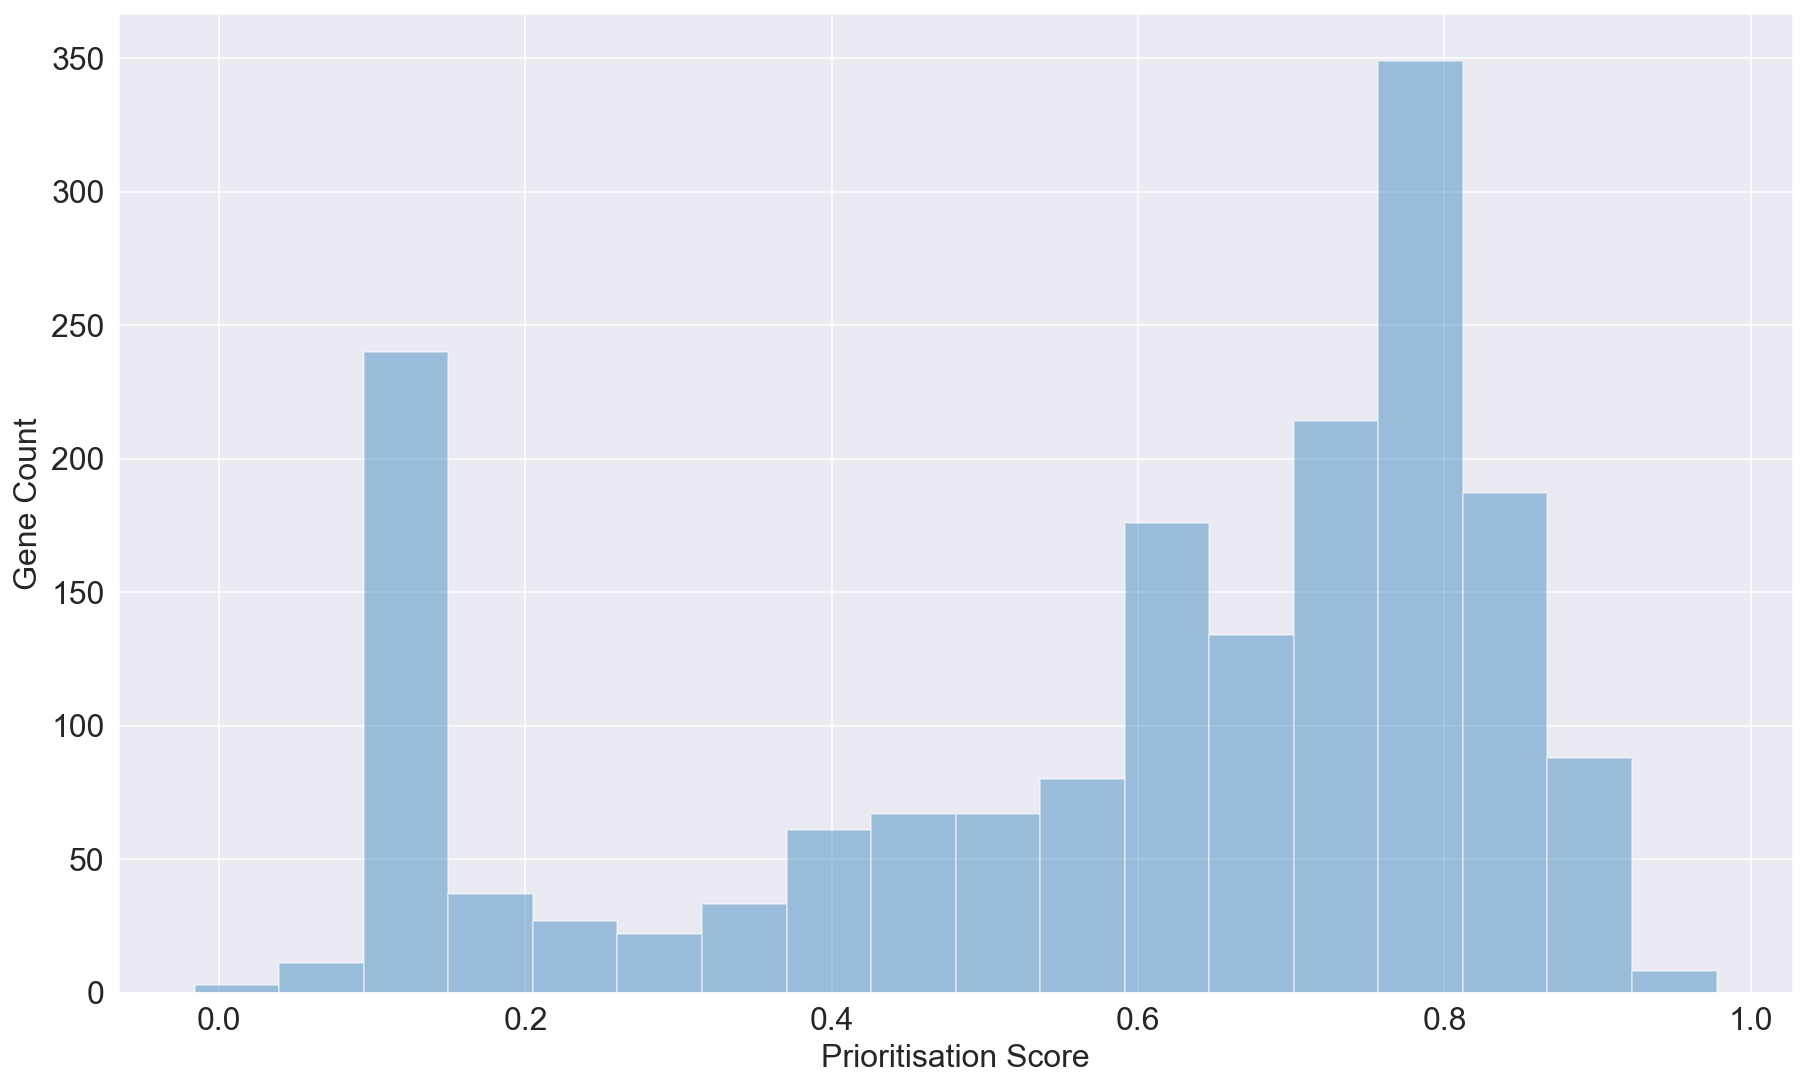

In [60]:
ax = sns.distplot(df_total["lgbm_Score"], kde=False, norm_hist=False)
ax.set_xlabel("Prioritisation Score", fontsize=16)
ax.set_ylabel("Gene Count", fontsize=16)
ax.tick_params(labelsize=16)

### SHAP Feature Importance Visualization:

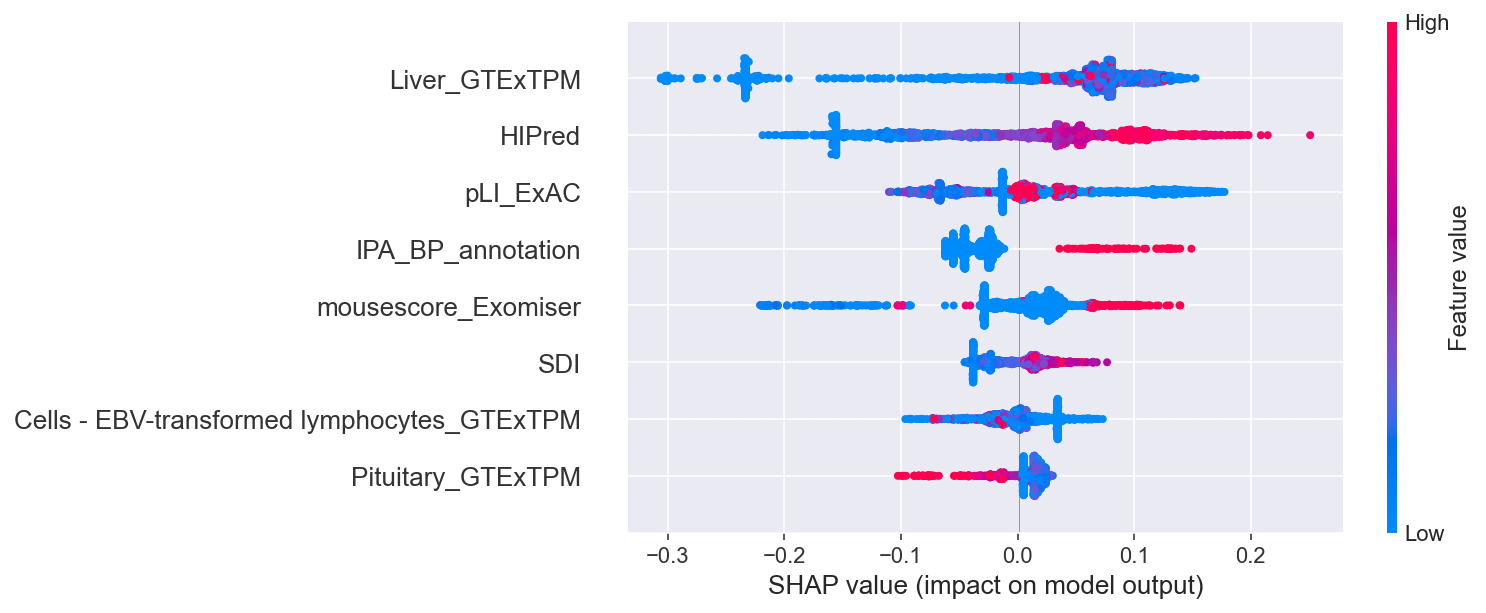

In [61]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X2)
shap.summary_plot(shap_values, X2)

In [62]:
expected_value = explainer.expected_value

In [63]:
select = range(8)
features = X2.iloc[select]
features_display = X2.loc[features.index]
shap_values = explainer.shap_values(X2)
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[:1804, :],
    X2.iloc[:1804, :],
    features_display,
)

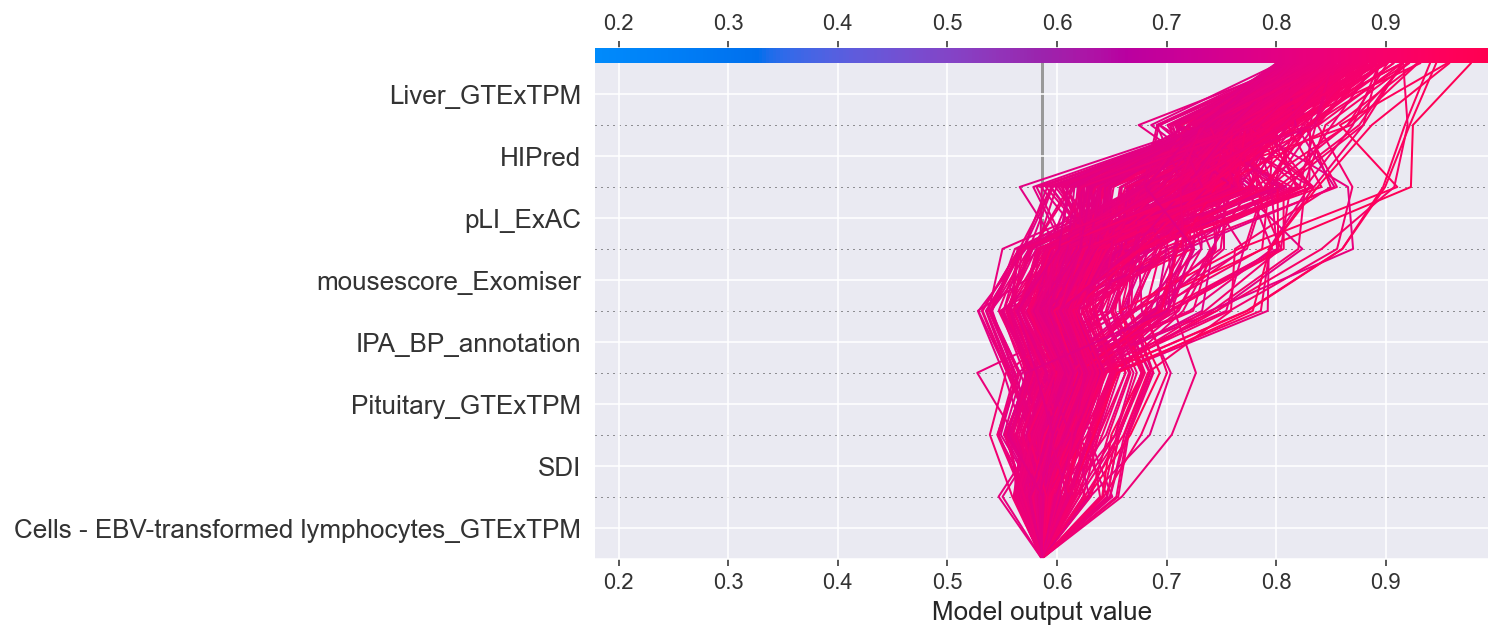

In [64]:
y_pred = model.predict(X2)

T = X2[(y_pred >= 0.8)]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)
r = shap.decision_plot(expected_value, sh, T, return_objects=True)

In [65]:
L = [331, 1505, 827, 1444, 306, 329, 463, 1513, 114, 1171]
X10 = X2.loc[L]

In [66]:
df10 = df_total.nlargest(10, "lgbm_Score", keep="last")
df10 = df10[
    [
       "SDI",
        "Liver_GTExTPM",
        "Cells - EBV-transformed lymphocytes_GTExTPM",
        "Pituitary_GTExTPM",
        "pLI_ExAC",
        "mousescore_Exomiser",
        "HIPred",
        "IPA_BP_annotation",
    ]
]

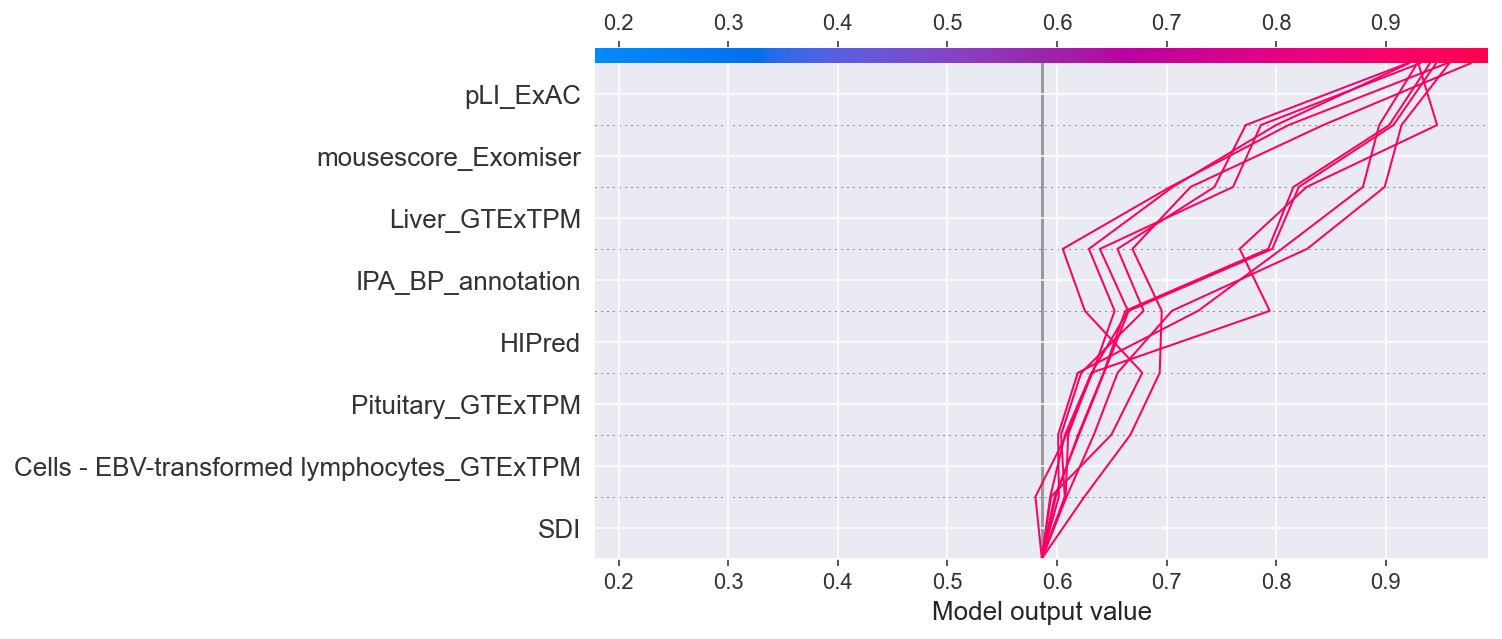

In [67]:
T = X10

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)
r = shap.decision_plot(expected_value, sh, T, return_objects=True)

In [68]:
select = range(8)
features = X10.iloc[select]
features_display = X10.loc[features.index]
shap_values = explainer.shap_values(X10)
shap.initjs()
shap.force_plot(
    explainer.expected_value, shap_values[:10, :], X10.iloc[:10, :], features_display,
)

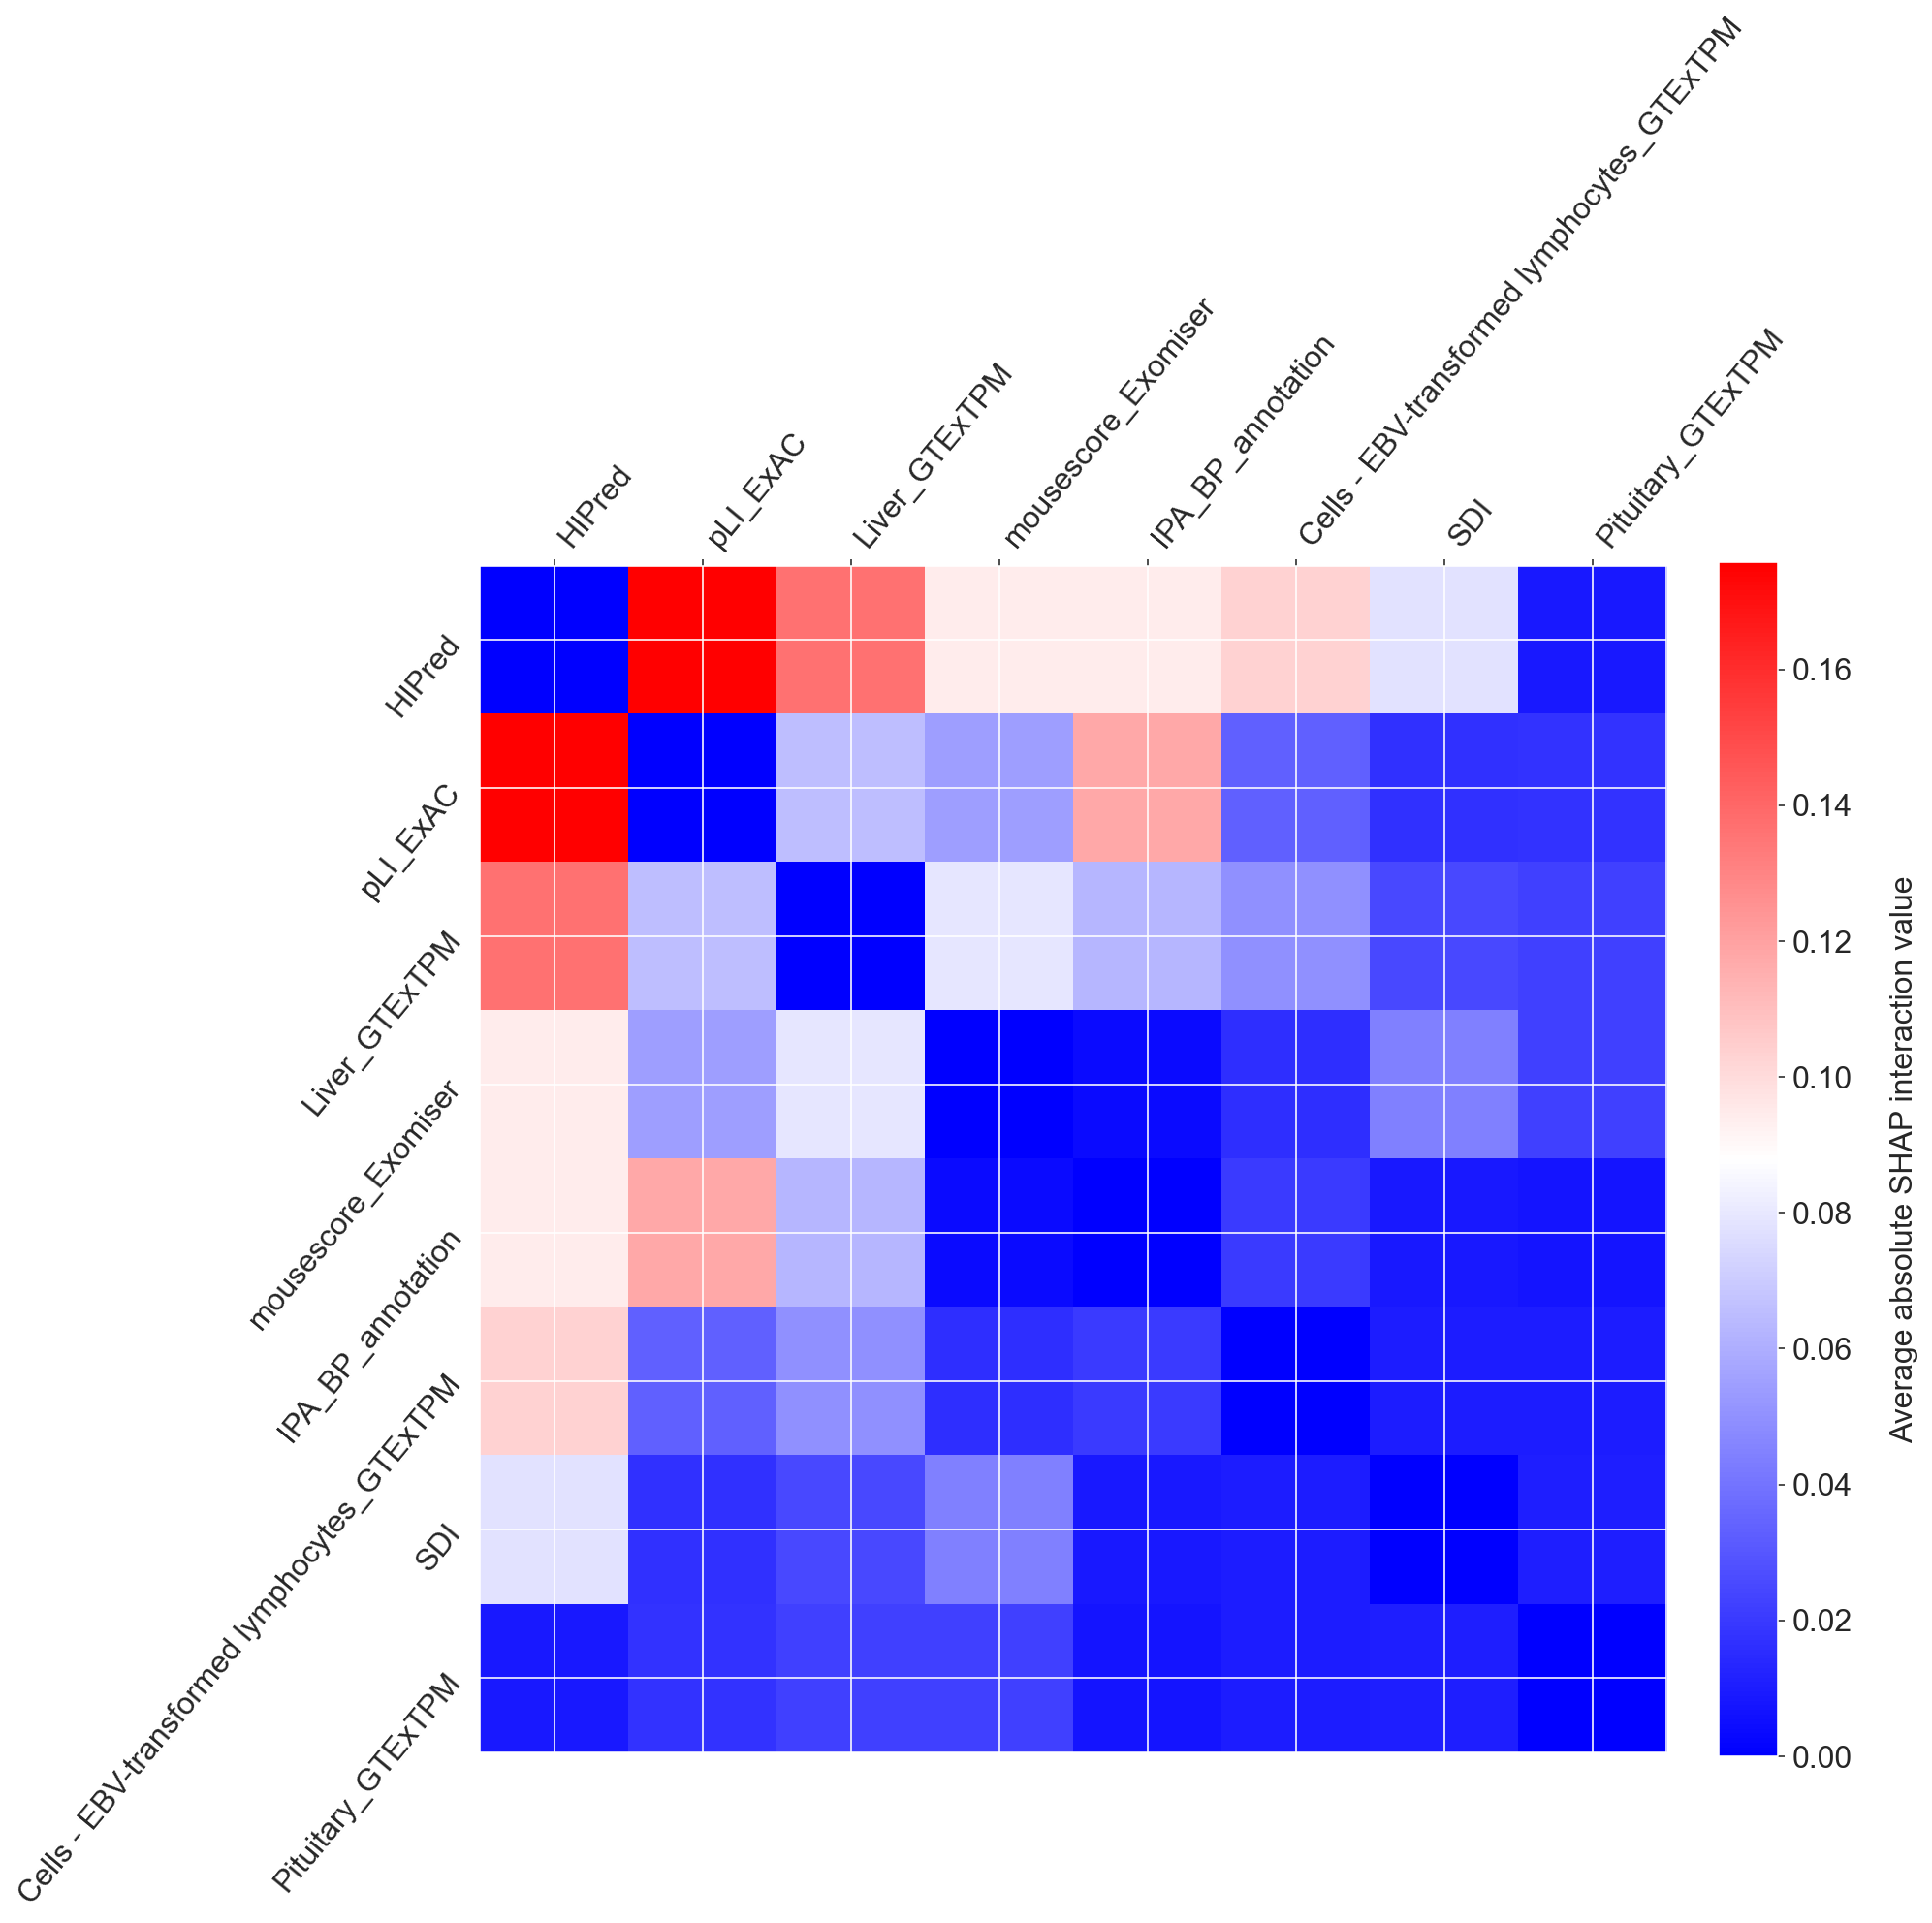

In [69]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X10)
X_interaction10 = pd.DataFrame(data=X10, columns=df10.columns)


tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i, i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds, :][:, inds]
plt.figure(figsize=(12, 12))
plt.imshow(
    tmp2, cmap="bwr"
)  # https://matplotlib.org/stable/gallery/color/colormap_reference.html
plt.yticks(
    range(tmp2.shape[0]),
    X_interaction10.columns[inds],
    rotation=50.4,
    horizontalalignment="right",
)
plt.xticks(
    range(tmp2.shape[0]),
    X_interaction10.columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label("Average absolute SHAP interaction value", size=16, labelpad=20)
plt.rcParams.update({"font.size": 16})
plt.show()

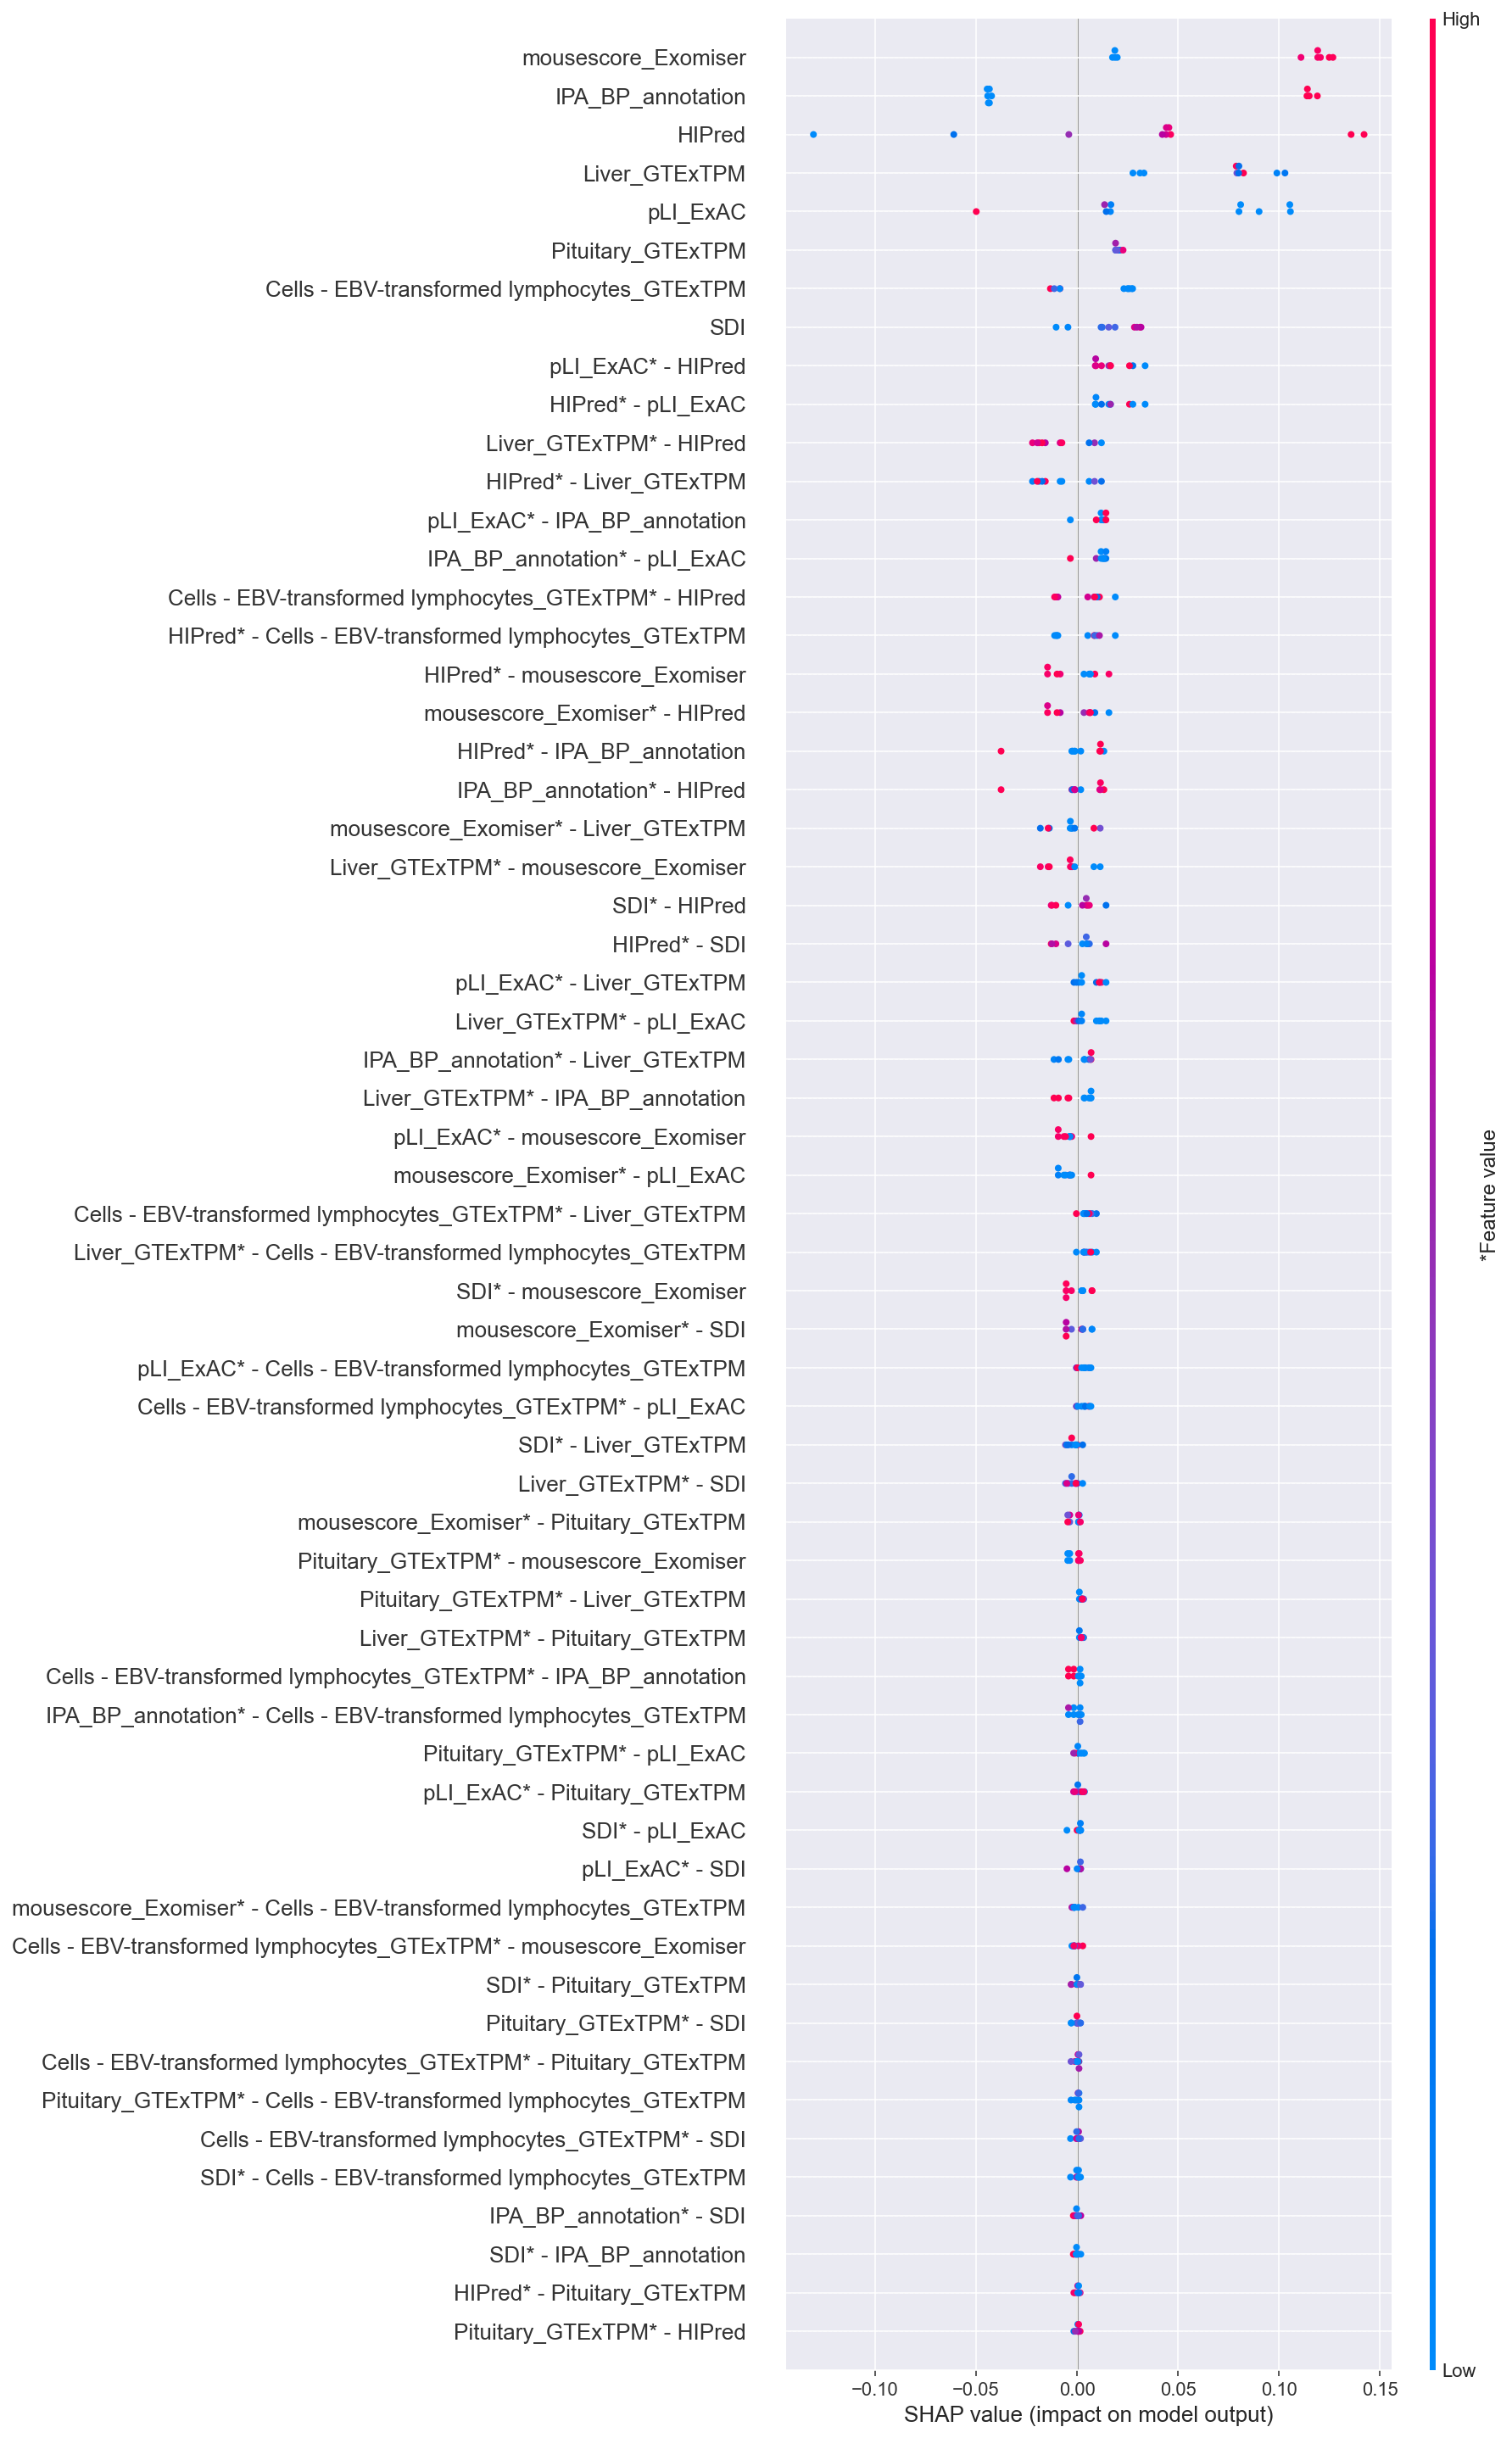

In [70]:
shap.summary_plot(shap_interaction_values, X10, max_display=60, plot_type="compact_dot")

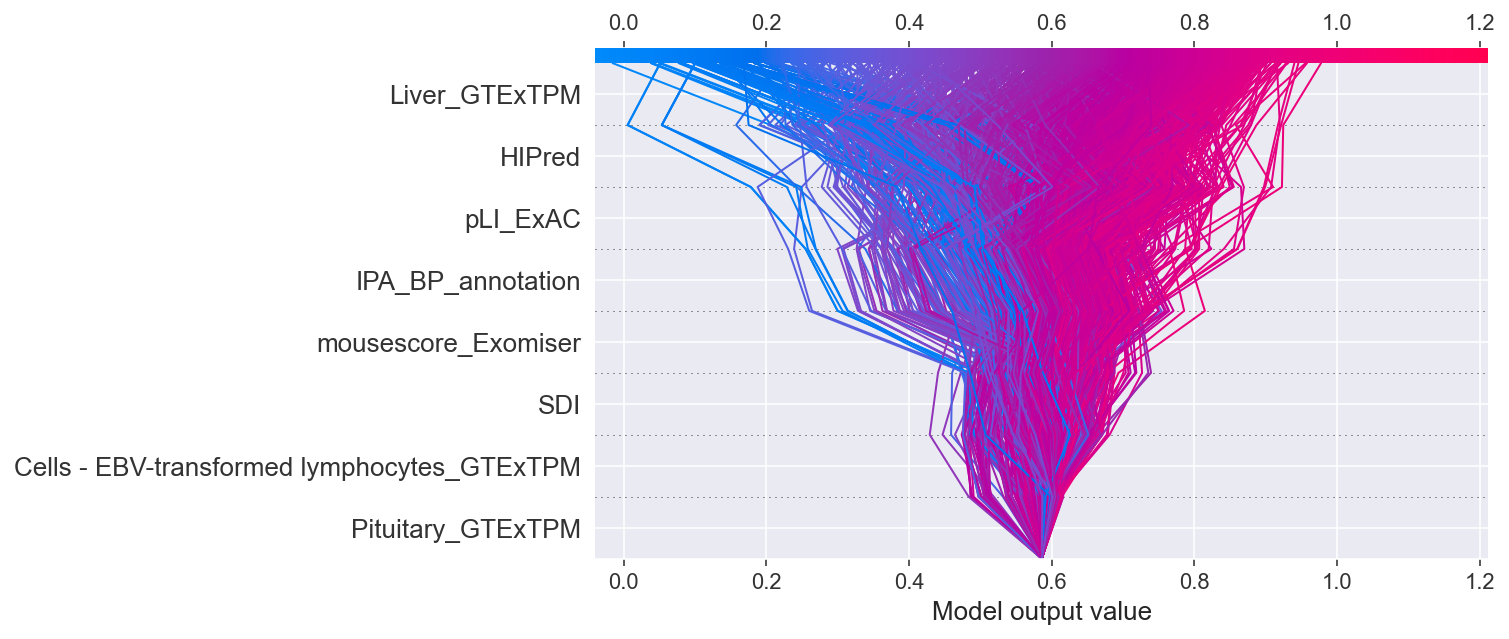

In [71]:
shap_values = explainer.shap_values(X2)
expected_value = explainer.expected_value
shap.decision_plot(expected_value, shap_values, X2)

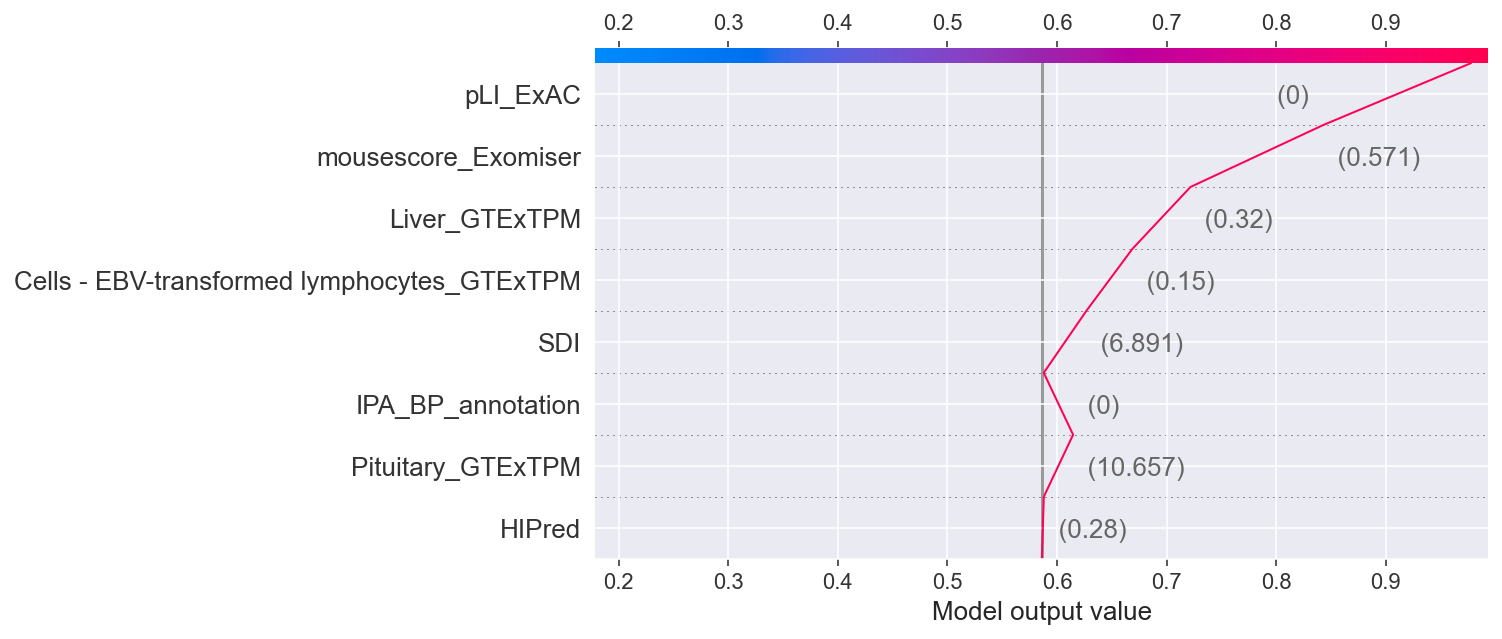

In [72]:
shap.decision_plot(expected_value, shap_values[331], X2.iloc[331])

In [73]:
gene1 = df_total[df_total["Gene"].str.contains("BDNF-AS")]
print(gene1)

        Gene  REVEL.max  MetaSVM_rankscore.max  MetaLR_rankscore.max  \
167  BDNF-AS        NaN                    NaN                   NaN   

     MCAP.max  wgEncodeBroadHmmHuvecHMM.count  betamax  logpval_gwascatalog  \
167       NaN                              44   0.6005            16.522879   

     Adipose - Subcutaneous_GTExTPM  Adipose - Visceral (Omentum)_GTExTPM  \
167                         1.55952                               1.27877   

     ...  MetaLR_rankscore  MetaSVM_rankscore  MutationAssessor_rankscore  \
167  ...           0.85277            0.86711                     0.80626   

     REVEL_score  fathmm-MKL_coding_score  integrated_fitCons_rankscore  \
167        0.848                  0.99098                       0.73137   

     LoFtool  GERP_Rankscore  BPlabel  XGB_Score  
167    0.212         0.98982  unknown   0.464697  

[1 rows x 169 columns]


In [74]:
X2.iloc[167]

SDI                                            3.923801
Liver_GTExTPM                                  0.884741
Cells - EBV-transformed lymphocytes_GTExTPM    0.714512
Pituitary_GTExTPM                              4.283150
pLI_ExAC                                       0.165509
mousescore_Exomiser                            0.004888
HIPred                                         0.417264
IPA_BP_annotation                              0.000000
Name: 167, dtype: float64

In [75]:
X_importance = X2
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(X2)
    p = shap.force_plot(
        explainerModel.expected_value,
        shap_values_Model[j],
        X2.iloc[[j]],
        feature_names=df2.columns,
    )
    return p


shap_plot(167)

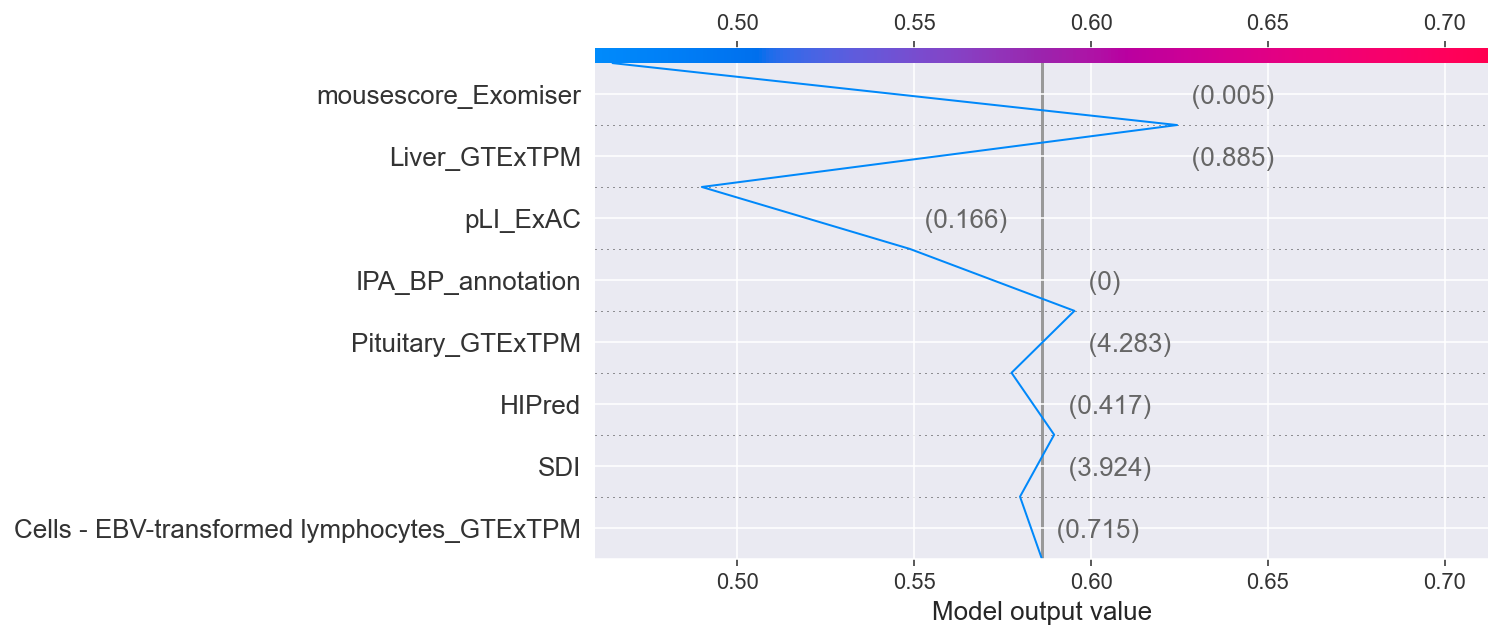

In [76]:
explainer = shap.TreeExplainer(model)

expected_value = explainer.expected_value
select = range(8)
features = X2.iloc[select]
features_display = X2.loc[features.index]
shap_values = explainer.shap_values(X2)
shap.decision_plot(
    expected_value, shap_values[167], X2.iloc[167], list(features_display)
)